# $\mathrm{Co_3O_4}$  Project EQCM

## Analyze Impedance Data

### Load Impedance Data and Apply a ZHIT Correction

In [1]:
import numpy as np
import pandas as pd
from galvani import BioLogic
import os
from numpy.typing import NDArray
from scipy.optimize import curve_fit 
from scipy.signal import savgol_filter

def load_data(file) -> None:
    mpr_file = BioLogic.MPRfile(file)
    data = pd.DataFrame(mpr_file.data)
    data.to_csv(f'{file[:-4]}.txt', sep = '\t')
    #print(data.head())
    frequency = data['freq/Hz']
    impedance = pd.Series(data['Re(Z)/Ohm'] - 1j* data['-Im(Z)/Ohm'], name='Z/Ohm')
    cutoff = 100e3
    idx_cutoff = np.argmin(np.abs(frequency - cutoff))
    frequency = frequency.iloc[idx_cutoff:]
    impedance = impedance.iloc[idx_cutoff:]
    potential = np.round(data['<Ewe>/V'], 2)
    fnames = pd.Series(np.full(np.shape(frequency), os.path.basename(file)), name = 'fname')
    return frequency, impedance, potential, fnames


class Measurement:

    def calc_integral(self, y: NDArray[np.float64], x: NDArray[np.float64], start: float, stop: float) -> NDArray[np.float64]:
        istart = np.argmin(np.abs(x - start))
        istop = np.argmin(np.abs(x - stop))
        integrand = x - np.roll(x, 1)
        integral = np.cumsum(y[istart:istop] * integrand[istart:istop])
        return integral

    def derivative(self, y: NDArray[np.float64], x: NDArray[np.float64]) -> NDArray[np.float64]:
        return (np.roll(y, -1)-y) / (np.roll(x, -1)-x)

    def constant_function(self, y_reconstructed: NDArray[np.float64], c: float) -> NDArray[np.float64]:
        return y_reconstructed + c

    def calc_shift_factor(self, y_exp: NDArray[np.float64], y_reconstructed: NDArray[np.float64]) -> NDArray[np.float64]:
        popt, _ = curve_fit(self.constant_function, y_reconstructed, y_exp, p0=np.average(y_exp))
        return popt

    def correct_ZHIT(self, frequency, impedance) -> tuple[NDArray[np.float64], NDArray[np.complex64]]:
        '''
        Performs the recunstruction of the magnitude from the phase using
        https://doc.zahner.de/technical_notes/z_hit.pdf
        '''
        self.impedance = impedance
        self.frequency = frequency
        impedance_uncorrected = impedance.copy()
        magnitude = savgol_filter(np.abs(self.impedance), 9, 1)
        ln_mag = np.log(magnitude)
        phase = savgol_filter(np.angle(self.impedance, deg=False), 9, 1)
        omega = 2 * np.pi * self.frequency
        ln_omega = np.log(omega)
        integral = self.calc_integral(phase, ln_omega, ln_omega[0], ln_omega[-1])
        deriv = self.derivative(phase, ln_omega)
        ln_abs_Z = 2 / np.pi * integral - np.pi / 6 * deriv[:-1]
        shift = self.calc_shift_factor(ln_mag[:-1], ln_abs_Z)
        ln_abs_Z_C = ln_abs_Z + shift
        
        self.frequency = self.frequency[:-1]
        self.impedance = np.exp(ln_abs_Z_C) * np.cos(phase[:-1]) + 1j * np.exp(ln_abs_Z_C) * np.sin(phase[:-1])



        '''
        fig, axs = plt.subplots(nrows=1, ncols=2, constrained_layout = True, figsize = (10,5))
        fig.suptitle('Z-Hit correction')
        sec = axs[0].twinx()
        axs[0].tick_params(which = 'both', direction = 'in', bottom = True, left = True)
        sec.tick_params(which = 'both', direction = 'in', bottom = False, left = False, right = True)
        axs[0].plot(self.frequency, np.abs(impedance_uncorrected)[:-1],               linestyle = '-',  color = 'black', label='experiment')
        axs[0].plot(self.frequency, np.exp(ln_abs_Z),   linestyle = '-',  color = 'red',   label='Z-Hit')
        axs[0].plot(self.frequency, np.exp(ln_abs_Z_C), linestyle = '-',  color = 'blue',  label='Z-Hit+Offest')  
        sec.plot(self.frequency, -np.angle(self.impedance),  linestyle = '--',    color = 'black')
        sec.plot(self.frequency, -phase[:-1],        linestyle = '--',    color = 'red')
        axs[0].set_yscale(r'log')
        axs[0].set_xscale(r'log')
        axs[0].set_xlabel(r'frequency (Hz)',                          fontsize = 14)
        axs[0].set_ylabel(r'magnitude impedance ($\mathrm{\Omega}$)', fontsize = 14)
        sec.set_ylabel(r'phase (rad)',                                fontsize = 14)
        
        axs[1].tick_params(which = 'both', direction = 'in', bottom = True, left = True, right = True, top = True)
        axs[1].plot(impedance_uncorrected.real, -impedance_uncorrected.imag,                 linestyle = '-',  color = 'black')
        axs[1].plot(self.impedance.real, -self.impedance.imag, linestyle = '-',  color = 'blue')  
        axs[1].set_xlabel(r'real part impedance ($\mathrm{\Omega}$)',     fontsize = 14)
        axs[1].set_ylabel(r'imaginary part impedance ($\mathrm{\Omega}$)', fontsize = 14)
        axs[1].set_aspect('equal')
        axs[1].set_ylim(bottom = np.min(np.hstack((impedance_uncorrected.real, -impedance_uncorrected.imag))), top   = np.max(np.hstack((impedance_uncorrected.real, -impedance_uncorrected.imag))))
        axs[1].set_xlim(left   = np.min(np.hstack((impedance_uncorrected.real, -impedance_uncorrected.imag))), right = np.max(np.hstack((impedance_uncorrected.real, -impedance_uncorrected.imag))))
        fig.legend(ncol = 4, frameon = False, loc = 'center', bbox_to_anchor = (0.5, -0.03))
        plt.savefig(fname = f'{file[:-4]}_ZHIT.tif', dpi = 600, pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')
        plt.show()  
        '''
        return self.frequency, self.impedance


AllEisData = pd.DataFrame()
files = []
root = os.getcwd()
if __name__ == "__main__":
    for dirpath, dirnames, filenames in os.walk(root):
        for file in filenames:
            if file.endswith('.mpr') and file.__contains__('PEIS'):
                files.append(os.path.join(dirpath, file))
    for ifile, file in enumerate(files): 
        frequency, impedance, potential, fnames = load_data(file)
        print(frequency, impedance)
        meas = Measurement()
        #frequency_NP = frequency.to_numpy()[:-1]
        #impedance_NP = impedance.to_numpy()[:-1]
        frequency_NP, impedance_NP = meas.correct_ZHIT(frequency.to_numpy(), impedance.to_numpy())
        frequency = pd.Series(frequency_NP, name = 'freq/Hz')
        impedance_re = pd.Series(impedance_NP.real, name = "Z'/Ohm")
        impedance_im = pd.Series(impedance_NP.imag, name = 'Z"/Ohm')
        EisData = pd.concat([frequency, impedance_re, impedance_im, potential, fnames], axis = 1)

        AllEisData = pd.concat([AllEisData, EisData])
    AllEisData_indexed = AllEisData.set_index(['fname', '<Ewe>/V'])
    AllEisData_indexed = AllEisData_indexed.sort_index()
AllEisData_indexed = AllEisData_indexed.reset_index().dropna(subset=['fname', '<Ewe>/V']).set_index(['fname', '<Ewe>/V'])
AllEisData_indexed

<>:68: SyntaxWarning: invalid escape sequence '\m'
<>:68: SyntaxWarning: invalid escape sequence '\m'
/var/folders/f2/krn3py8536556jbm969hx5380000gn/T/ipykernel_29079/3337660273.py:68: SyntaxWarning: invalid escape sequence '\m'
  '''


0     100003.710938
1      79433.273438
2      63093.828125
3      50122.476562
4      39814.062500
          ...      
56         0.251173
57         0.199573
58         0.158469
59         0.125907
60         0.100022
Name: freq/Hz, Length: 61, dtype: float32 0     -239.670746+  632.182190j
1     -199.292450+  392.381622j
2        6.773082+    3.919977j
3        7.109711+    2.967404j
4        7.311452+    2.280535j
                ...            
56    2553.463867- 6253.483887j
57    3339.385742- 7536.034668j
58    4339.035156- 9135.669922j
59    5519.799805-11069.902344j
60    6895.039551-13318.493164j
Name: Z/Ohm, Length: 61, dtype: complex64
0     100003.710938
1      79433.273438
2      63093.828125
3      50122.476562
4      39814.062500
          ...      
56         0.251173
57         0.199573
58         0.158469
59         0.125907
60         0.100022
Name: freq/Hz, Length: 61, dtype: float32 0      -238.400375+  635.213318j
1      -194.851593+  393.630280j
2         6.8479

freq/Hz  \
fname                                              <Ewe>/V                  
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_... -0.00    100003.710938   
                                                   -0.00     79433.273438   
                                                   -0.00     63093.828125   
                                                   -0.00     50122.476562   
                                                   -0.00     39814.062500   
...                                                                   ...   
CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA...  0.75         0.251173   
                                                    0.75         0.199573   
                                                    0.75         0.158469   
                                                    0.75         0.125907   
                                                    0.75              NaN   

                                                                Z'/Ohm  \
fname                                              <Ewe>/V               
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_... -0.00     -0.195763   
                                                   -0.00      2.635067   
                                                   -0.00      4.487898   
                                                   -0.00      5.708525   
                                                   -0.00      6.890655   
...                                                                ...   
CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA...  0.75    262.184757   
                                                    0.75    263.317422   
                                                    0.75    264.432645   
                                                    0.75    265.520556   
                                                    0.75           NaN   

                                                               Z"/Ohm  
fname                                              <Ewe>/V             
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_... -0.00    14.584977  
                                                   -0.00    11.675679  
                                                   -0.00     9.118669  
                                                   -0.00     6.877966  
                                                   -0.00     5.158870  
...                                                               ...  
CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA...  0.75    -7.878386  
                                                    0.75    -7.724458  
                                                    0.75    -7.568421  
                                                    0.75    -7.410037  
                                                    0.75          NaN  

[3843 rows x 3 columns]

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_02_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 12.1 ± 0.6 $\mathrm{\Omega}$   $R_1$ = 16222.9 ± 730.2 $\mathrm{\Omega}$   $R_2$ = 80676.3 ± 2523.1 $\mathrm{\Omega}$   
$R_3$ = 246772.4 ± 18644.9 $\mathrm{\Omega}$   $C_1$ = 30.4 ± 0.1 $\mathrm{\mu F}$   $C_2$ = 9.0 ± 0.2 $\mathrm{\mu F}$   
$C_3$ = 15.7 ± 0.3 $\mathrm{\mu F}$   


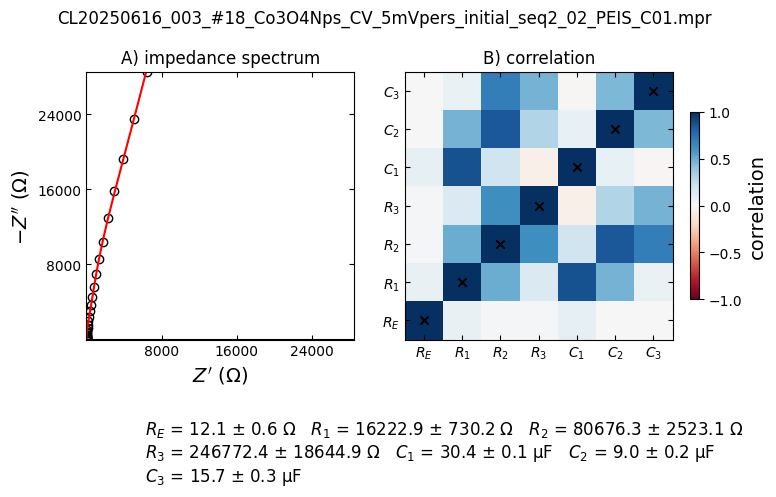

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_05_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 12.0 ± 0.5 $\mathrm{\Omega}$   $R_1$ = 16729.0 ± 774.9 $\mathrm{\Omega}$   $R_2$ = 86918.2 ± 3789.0 $\mathrm{\Omega}$   
$R_3$ = 294551.4 ± 19547.0 $\mathrm{\Omega}$   $C_1$ = 32.3 ± 0.1 $\mathrm{\mu F}$   $C_2$ = 9.0 ± 0.2 $\mathrm{\mu F}$   
$C_3$ = 11.8 ± 0.2 $\mathrm{\mu F}$   


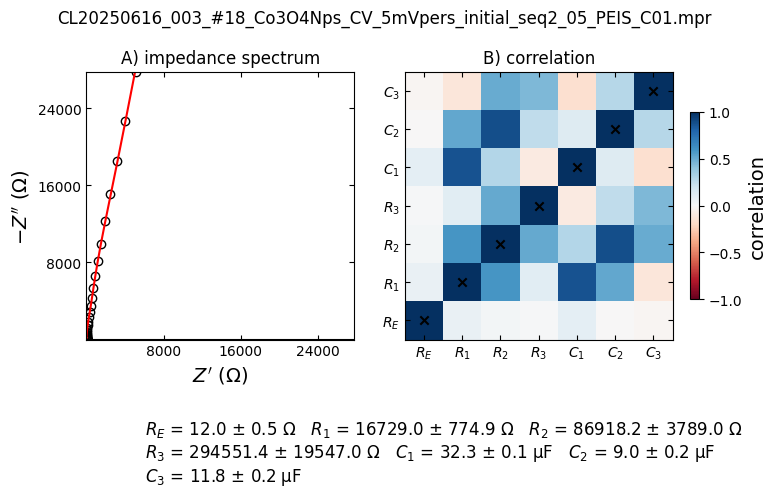

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_08_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 11.9 ± 0.5 $\mathrm{\Omega}$   $R_1$ = 6147.1 ± 277.6 $\mathrm{\Omega}$   $R_2$ = 22068.1 ± 524.1 $\mathrm{\Omega}$   
$R_3$ = 61073.2 ± 3032.6 $\mathrm{\Omega}$   $C_1$ = 48.0 ± 0.3 $\mathrm{\mu F}$   $C_2$ = 21.8 ± 0.5 $\mathrm{\mu F}$   
$C_3$ = 52.7 ± 0.8 $\mathrm{\mu F}$   


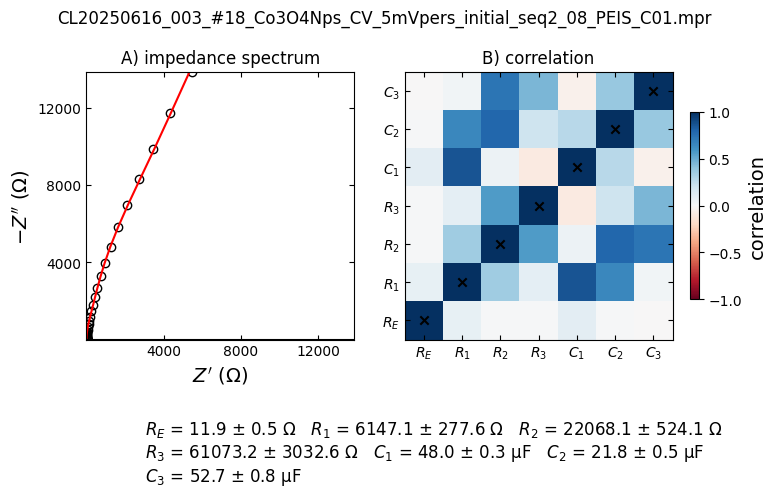

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_11_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 12.2 ± 0.6 $\mathrm{\Omega}$   $R_1$ = 6368.1 ± 284.5 $\mathrm{\Omega}$   $R_2$ = 17499.5 ± 415.9 $\mathrm{\Omega}$   
$R_3$ = 44095.3 ± 1952.6 $\mathrm{\Omega}$   $C_1$ = 43.2 ± 0.3 $\mathrm{\mu F}$   $C_2$ = 23.4 ± 0.7 $\mathrm{\mu F}$   
$C_3$ = 64.7 ± 1.1 $\mathrm{\mu F}$   


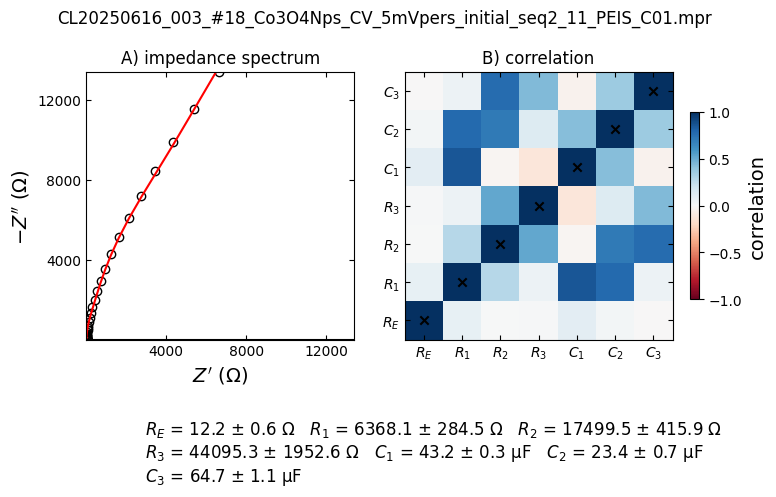

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_14_PEIS_C01.mpr
---weight 0.3---
$R_E$ = 12.6 ± 0.8 $\mathrm{\Omega}$   $R_1$ = 7427.1 ± 397.8 $\mathrm{\Omega}$   $R_2$ = 17909.5 ± 426.8 $\mathrm{\Omega}$   
$R_3$ = 36183.3 ± 1484.3 $\mathrm{\Omega}$   $C_1$ = 32.4 ± 0.3 $\mathrm{\mu F}$   $C_2$ = 18.9 ± 0.8 $\mathrm{\mu F}$   
$C_3$ = 65.9 ± 1.5 $\mathrm{\mu F}$   


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


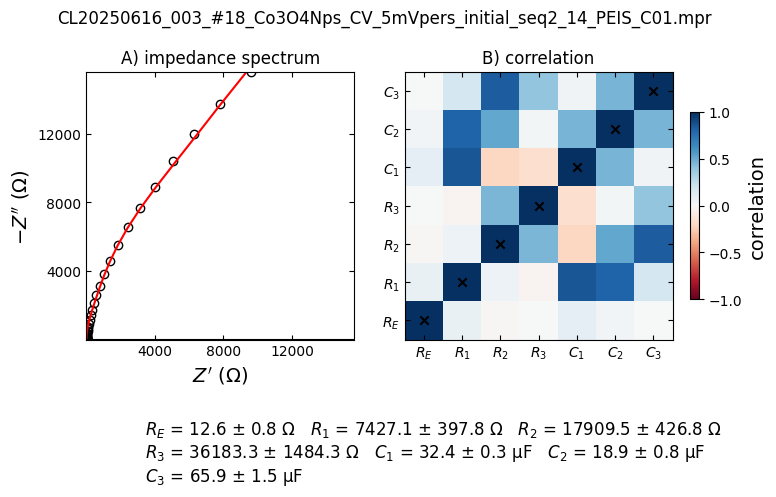

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_17_PEIS_C01.mpr
---weight 0.3---
$R_E$ = 13.2 ± 0.9 $\mathrm{\Omega}$   $R_1$ = 8045.6 ± 319.3 $\mathrm{\Omega}$   $R_2$ = 19143.9 ± 389.2 $\mathrm{\Omega}$   
$R_3$ = 31436.4 ± 1560.1 $\mathrm{\Omega}$   $C_1$ = 27.4 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 20.1 ± 0.7 $\mathrm{\mu F}$   
$C_3$ = 79.0 ± 2.2 $\mathrm{\mu F}$   


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


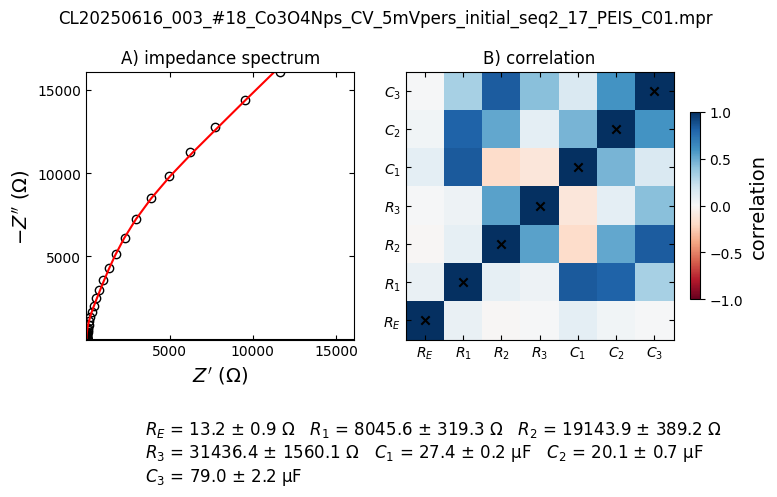

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_20_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 13.4 ± 1.0 $\mathrm{\Omega}$   $R_1$ = 10828.0 ± 484.2 $\mathrm{\Omega}$   $R_2$ = 28194.1 ± 812.3 $\mathrm{\Omega}$   
$R_3$ = 61600.1 ± 3306.9 $\mathrm{\Omega}$   $C_1$ = 26.2 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 16.0 ± 0.6 $\mathrm{\mu F}$   
$C_3$ = 43.9 ± 1.1 $\mathrm{\mu F}$   


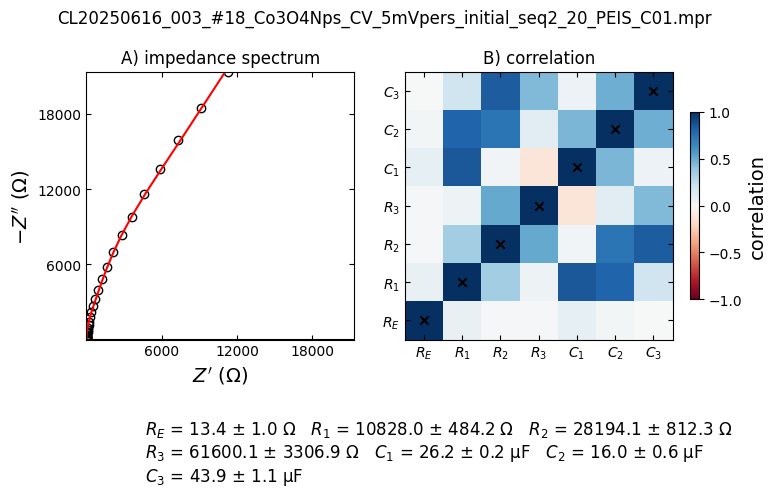

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_03_PEIS_C01.mpr
---weight 0.3---
$R_E$ = 13.4 ± 1.0 $\mathrm{\Omega}$   $R_1$ = 11047.1 ± 488.8 $\mathrm{\Omega}$   $R_2$ = 29289.0 ± 649.3 $\mathrm{\Omega}$   
$R_3$ = 53589.1 ± 3080.9 $\mathrm{\Omega}$   $C_1$ = 26.1 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 14.9 ± 0.5 $\mathrm{\mu F}$   
$C_3$ = 52.2 ± 1.4 $\mathrm{\mu F}$   


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


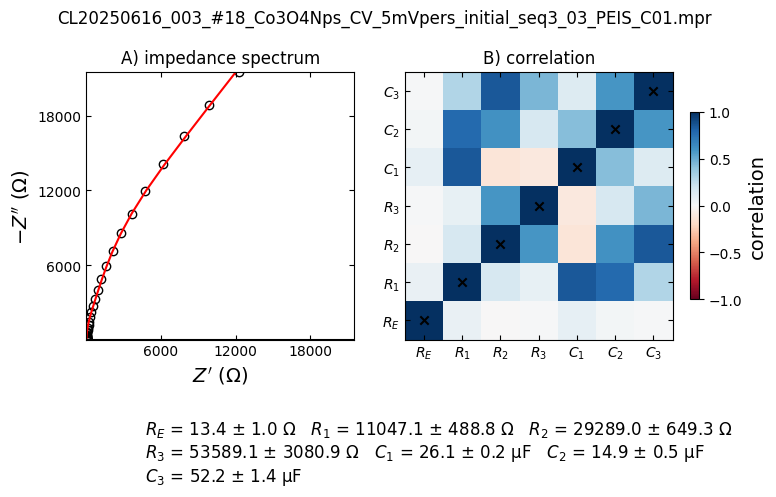

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_06_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 13.6 ± 1.0 $\mathrm{\Omega}$   $R_1$ = 11932.4 ± 455.7 $\mathrm{\Omega}$   $R_2$ = 29110.2 ± 775.9 $\mathrm{\Omega}$   
$R_3$ = 55674.3 ± 3874.9 $\mathrm{\Omega}$   $C_1$ = 25.9 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 17.3 ± 0.6 $\mathrm{\mu F}$   
$C_3$ = 52.8 ± 1.6 $\mathrm{\mu F}$   


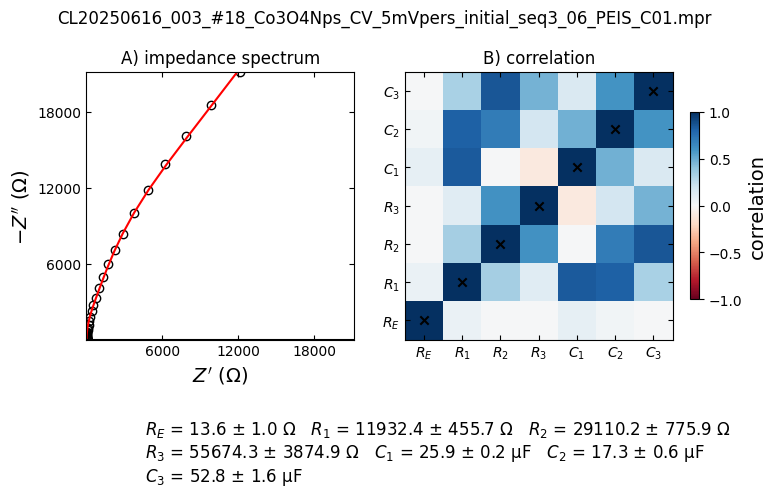

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_09_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 13.4 ± 0.9 $\mathrm{\Omega}$   $R_1$ = 11273.1 ± 382.5 $\mathrm{\Omega}$   $R_2$ = 24298.8 ± 408.3 $\mathrm{\Omega}$   
$R_3$ = 33869.6 ± 2711.2 $\mathrm{\Omega}$   $C_1$ = 25.6 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 17.8 ± 0.5 $\mathrm{\mu F}$   
$C_3$ = 92.5 ± 3.0 $\mathrm{\mu F}$   


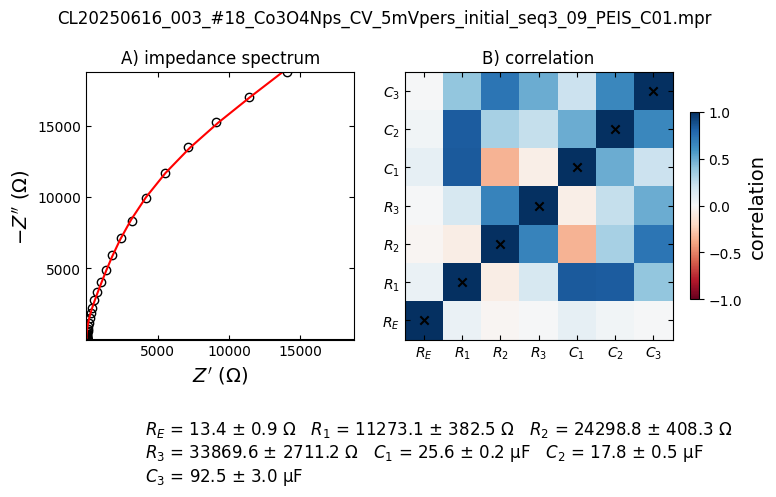

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_12_PEIS_C01.mpr
---weight 0.3---
$R_E$ = 13.5 ± 1.0 $\mathrm{\Omega}$   $R_1$ = 11042.9 ± 368.3 $\mathrm{\Omega}$   $R_2$ = 17916.7 ± 343.1 $\mathrm{\Omega}$   
$R_3$ = 20384.1 ± 1613.6 $\mathrm{\Omega}$   $C_1$ = 25.6 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 21.7 ± 0.9 $\mathrm{\mu F}$   
$C_3$ = 130.4 ± 5.7 $\mathrm{\mu F}$   


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


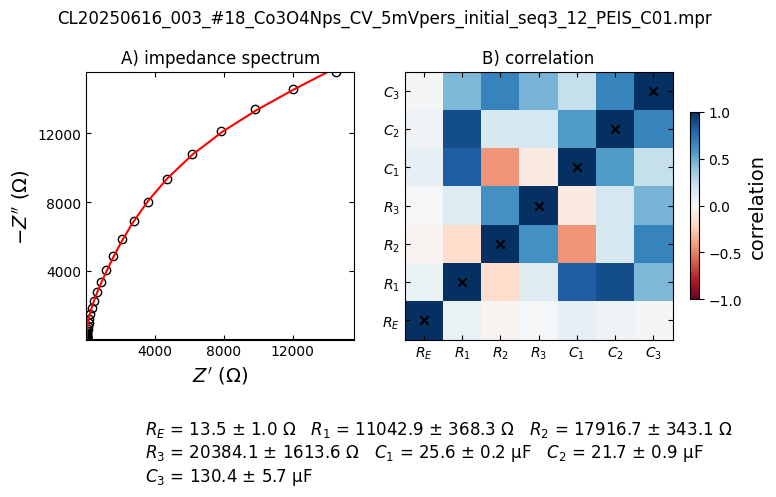

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_15_PEIS_C01.mpr
---weight 0.3---
$R_E$ = 13.2 ± 1.0 $\mathrm{\Omega}$   $R_1$ = 8528.9 ± 423.7 $\mathrm{\Omega}$   $R_2$ = 11137.6 ± 316.6 $\mathrm{\Omega}$   
$R_3$ = 6161.5 ± 259.3 $\mathrm{\Omega}$   $C_1$ = 25.1 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 19.2 ± 1.3 $\mathrm{\mu F}$   
$C_3$ = 194.9 ± 15.7 $\mathrm{\mu F}$   


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


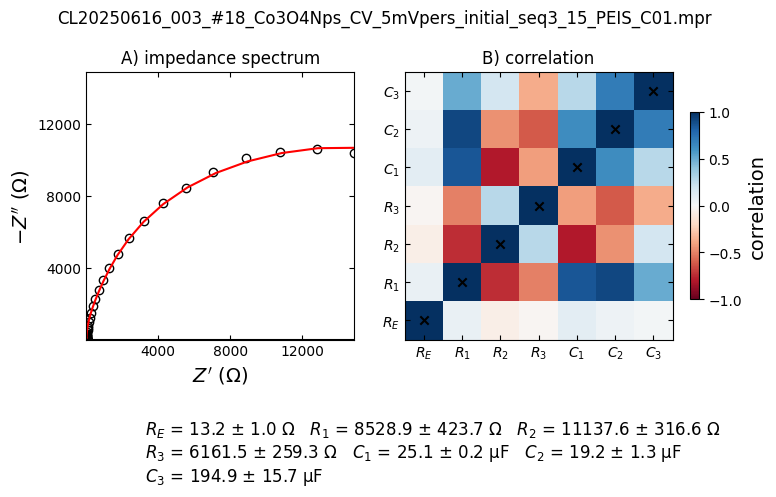

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_18_PEIS_C01.mpr
---weight 0.3---
$R_E$ = 12.7 ± 0.9 $\mathrm{\Omega}$   $R_1$ = 5040.6 ± 446.3 $\mathrm{\Omega}$   $R_2$ = 7730.5 ± 348.7 $\mathrm{\Omega}$   
$R_3$ = 3703.2 ± 179.9 $\mathrm{\Omega}$   $C_1$ = 24.2 ± 0.3 $\mathrm{\mu F}$   $C_2$ = 12.9 ± 1.2 $\mathrm{\mu F}$   
$C_3$ = 156.3 ± 13.2 $\mathrm{\mu F}$   


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


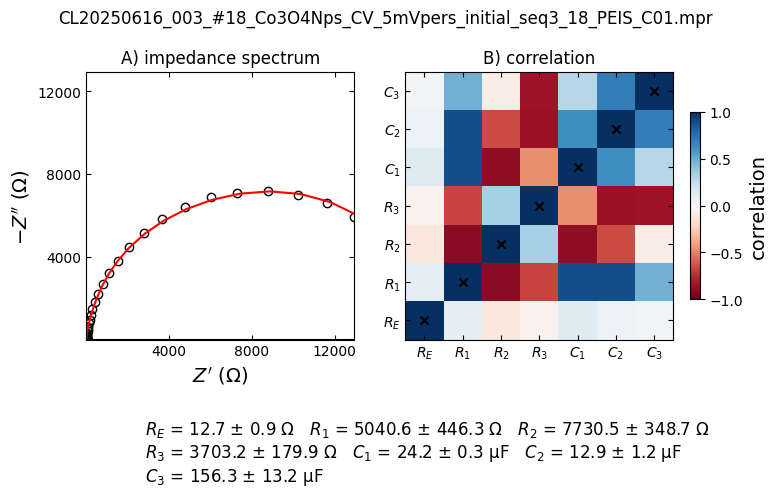

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq4_03_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 12.5 ± 0.8 $\mathrm{\Omega}$   $R_1$ = 3247.9 ± 395.6 $\mathrm{\Omega}$   $R_2$ = 5593.0 ± 319.6 $\mathrm{\Omega}$   
$R_3$ = 2310.7 ± 146.8 $\mathrm{\Omega}$   $C_1$ = 23.5 ± 0.4 $\mathrm{\mu F}$   $C_2$ = 11.4 ± 1.2 $\mathrm{\mu F}$   
$C_3$ = 159.8 ± 17.3 $\mathrm{\mu F}$   


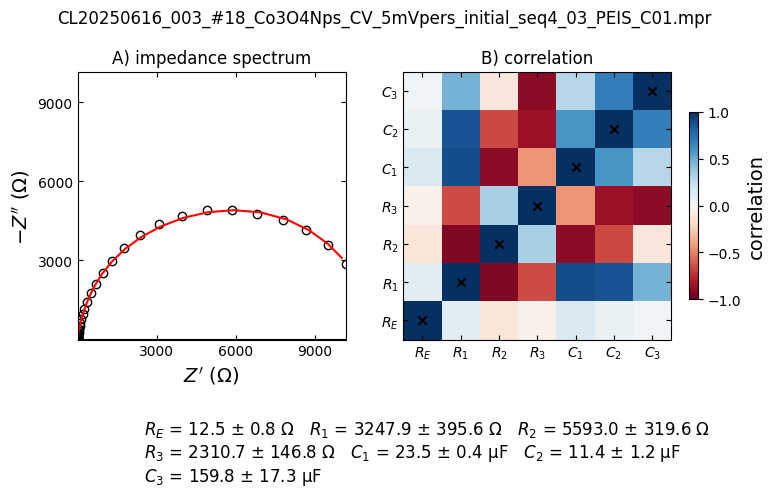

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq4_06_PEIS_C01.mpr
---weight 0.3---
$R_E$ = 12.4 ± 0.8 $\mathrm{\Omega}$   $R_1$ = 2852.2 ± 298.5 $\mathrm{\Omega}$   $R_2$ = 3369.7 ± 246.6 $\mathrm{\Omega}$   
$R_3$ = 1296.8 ± 93.3 $\mathrm{\Omega}$   $C_1$ = 23.6 ± 0.4 $\mathrm{\mu F}$   $C_2$ = 15.6 ± 2.3 $\mathrm{\mu F}$   
$C_3$ = 273.4 ± 36.0 $\mathrm{\mu F}$   


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


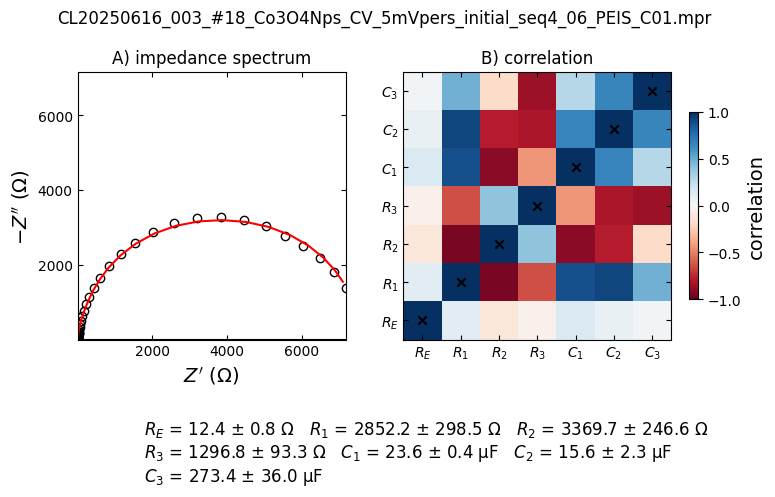

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq4_09_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 12.3 ± 0.7 $\mathrm{\Omega}$   $R_1$ = 1990.8 ± 237.5 $\mathrm{\Omega}$   $R_2$ = 2186.8 ± 198.1 $\mathrm{\Omega}$   
$R_3$ = 777.5 ± 70.9 $\mathrm{\Omega}$   $C_1$ = 23.2 ± 0.4 $\mathrm{\mu F}$   $C_2$ = 16.0 ± 2.9 $\mathrm{\mu F}$   
$C_3$ = 304.0 ± 50.5 $\mathrm{\mu F}$   


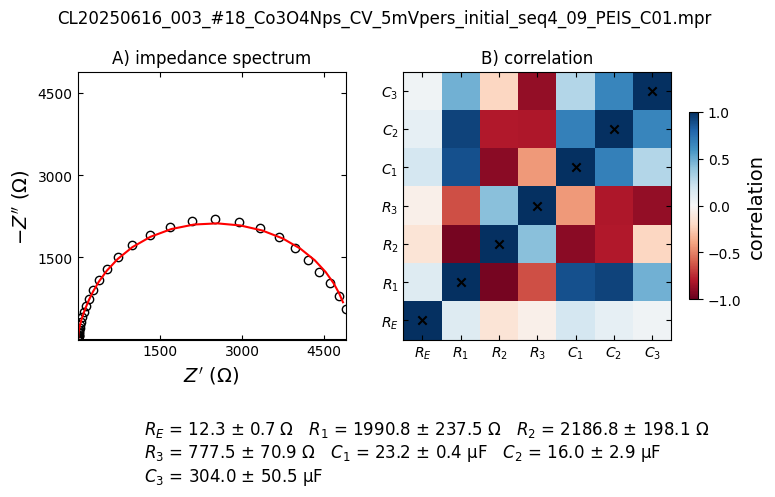

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq4_12_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 12.3 ± 0.6 $\mathrm{\Omega}$   $R_1$ = 1530.7 ± 166.0 $\mathrm{\Omega}$   $R_2$ = 1347.0 ± 139.6 $\mathrm{\Omega}$   
$R_3$ = 421.5 ± 47.7 $\mathrm{\Omega}$   $C_1$ = 23.0 ± 0.4 $\mathrm{\mu F}$   $C_2$ = 19.5 ± 4.2 $\mathrm{\mu F}$   
$C_3$ = 430.8 ± 92.3 $\mathrm{\mu F}$   


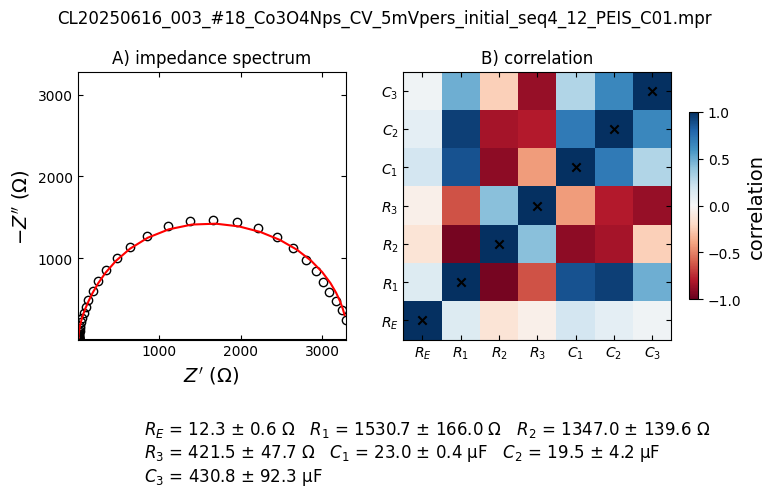

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq4_15_PEIS_C01.mpr
---weight 0.3---
$R_E$ = 12.1 ± 0.4 $\mathrm{\Omega}$   $R_1$ = 524.4 ± 104.7 $\mathrm{\Omega}$   $R_2$ = 632.3 ± 89.8 $\mathrm{\Omega}$   
$R_3$ = 190.1 ± 27.3 $\mathrm{\Omega}$   $C_1$ = 21.3 ± 0.6 $\mathrm{\mu F}$   $C_2$ = 12.1 ± 3.1 $\mathrm{\mu F}$   
$C_3$ = 270.0 ± 68.7 $\mathrm{\mu F}$   


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


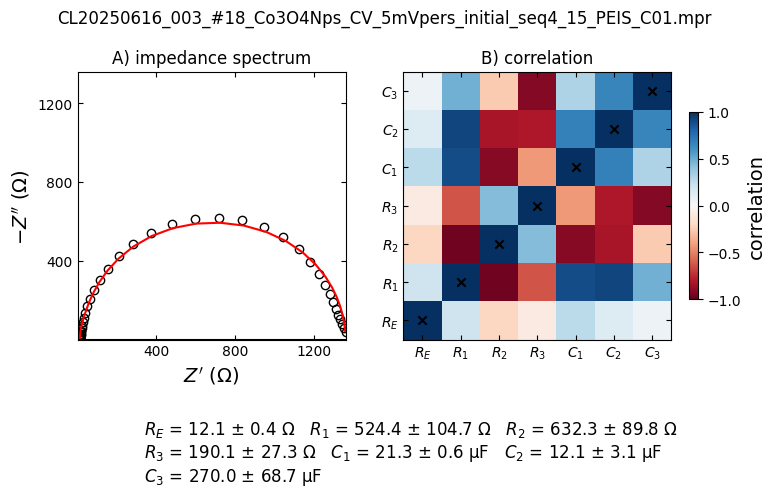

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq4_18_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 11.7 ± 0.2 $\mathrm{\Omega}$   $R_1$ = 158.3 ± 45.0 $\mathrm{\Omega}$   $R_2$ = 382.7 ± 40.0 $\mathrm{\Omega}$   
$R_3$ = 112.3 ± 11.3 $\mathrm{\Omega}$   $C_1$ = 19.0 ± 0.7 $\mathrm{\mu F}$   $C_2$ = 8.1 ± 1.1 $\mathrm{\mu F}$   
$C_3$ = 197.5 ± 37.3 $\mathrm{\mu F}$   


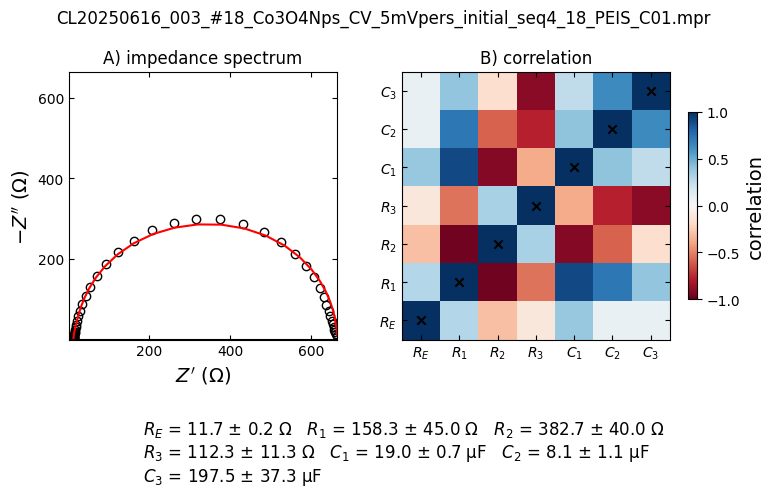

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq5_03_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 11.7 ± 0.2 $\mathrm{\Omega}$   $R_1$ = 98.7 ± 24.6 $\mathrm{\Omega}$   $R_2$ = 227.6 ± 21.8 $\mathrm{\Omega}$   
$R_3$ = 57.5 ± 6.9 $\mathrm{\Omega}$   $C_1$ = 17.7 ± 0.6 $\mathrm{\mu F}$   $C_2$ = 8.5 ± 1.1 $\mathrm{\mu F}$   
$C_3$ = 219.3 ± 50.1 $\mathrm{\mu F}$   


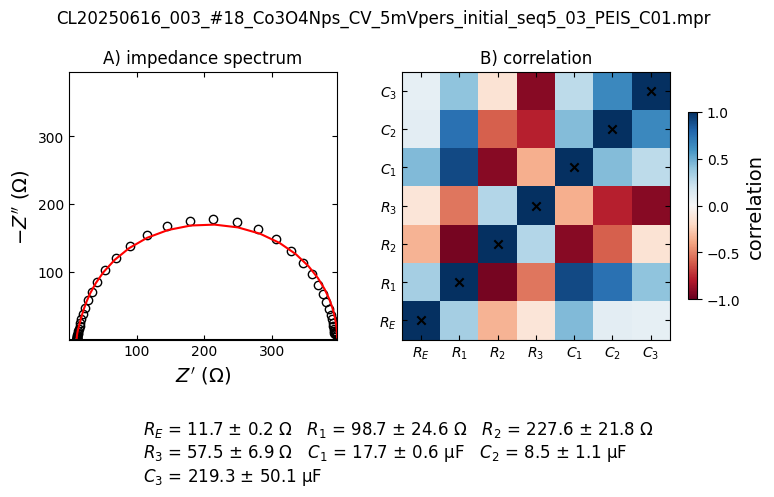

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq5_06_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 11.7 ± 0.1 $\mathrm{\Omega}$   $R_1$ = 72.9 ± 14.2 $\mathrm{\Omega}$   $R_2$ = 122.7 ± 11.9 $\mathrm{\Omega}$   
$R_3$ = 30.1 ± 5.2 $\mathrm{\Omega}$   $C_1$ = 16.8 ± 0.5 $\mathrm{\mu F}$   $C_2$ = 10.2 ± 1.7 $\mathrm{\mu F}$   
$C_3$ = 216.7 ± 67.8 $\mathrm{\mu F}$   


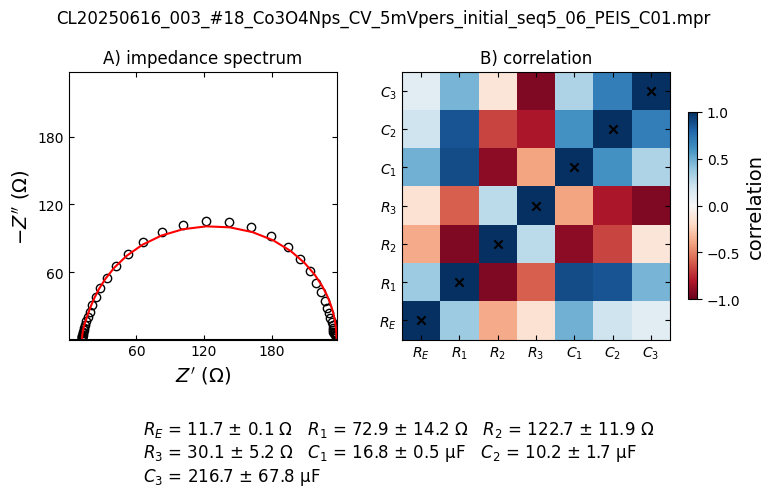

CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq2_02_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 23.3 ± 1.4 $\mathrm{\Omega}$   $R_1$ = 22712.4 ± 960.8 $\mathrm{\Omega}$   $R_2$ = 55121.6 ± 1900.4 $\mathrm{\Omega}$   
$R_3$ = 129806.6 ± 6755.0 $\mathrm{\Omega}$   $C_1$ = 16.7 ± 0.1 $\mathrm{\mu F}$   $C_2$ = 9.1 ± 0.4 $\mathrm{\mu F}$   
$C_3$ = 21.0 ± 0.5 $\mathrm{\mu F}$   


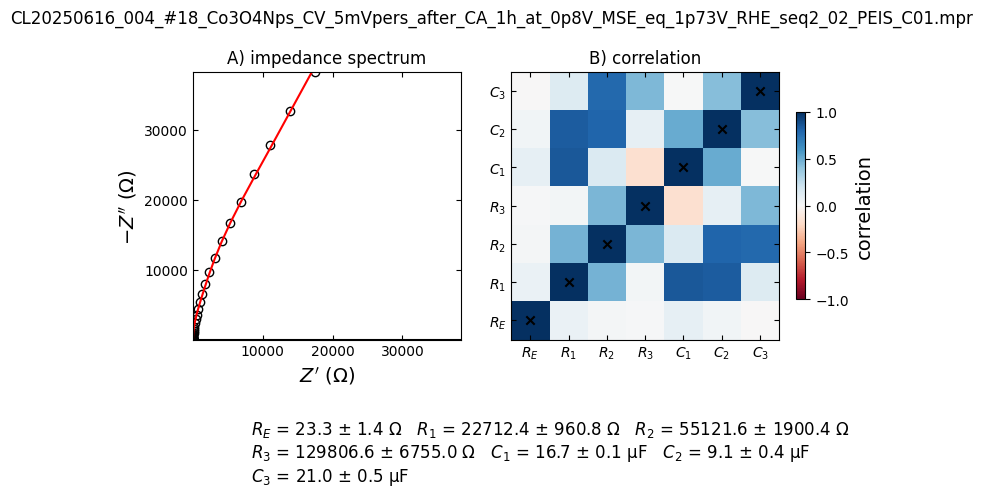

CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq2_05_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 23.4 ± 1.2 $\mathrm{\Omega}$   $R_1$ = 25408.3 ± 1165.3 $\mathrm{\Omega}$   $R_2$ = 92528.4 ± 3289.8 $\mathrm{\Omega}$   
$R_3$ = 267182.9 ± 16601.9 $\mathrm{\Omega}$   $C_1$ = 17.6 ± 0.1 $\mathrm{\mu F}$   $C_2$ = 6.6 ± 0.2 $\mathrm{\mu F}$   
$C_3$ = 12.3 ± 0.2 $\mathrm{\mu F}$   


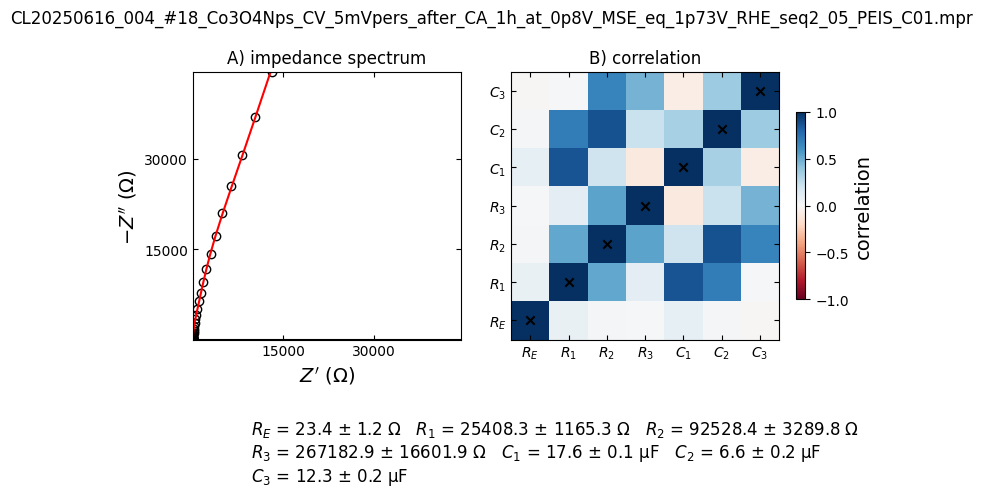

CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq2_08_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 23.2 ± 1.1 $\mathrm{\Omega}$   $R_1$ = 12488.7 ± 596.9 $\mathrm{\Omega}$   $R_2$ = 38490.3 ± 861.5 $\mathrm{\Omega}$   
$R_3$ = 87751.2 ± 4698.4 $\mathrm{\Omega}$   $C_1$ = 22.3 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 11.3 ± 0.3 $\mathrm{\mu F}$   
$C_3$ = 34.4 ± 0.7 $\mathrm{\mu F}$   


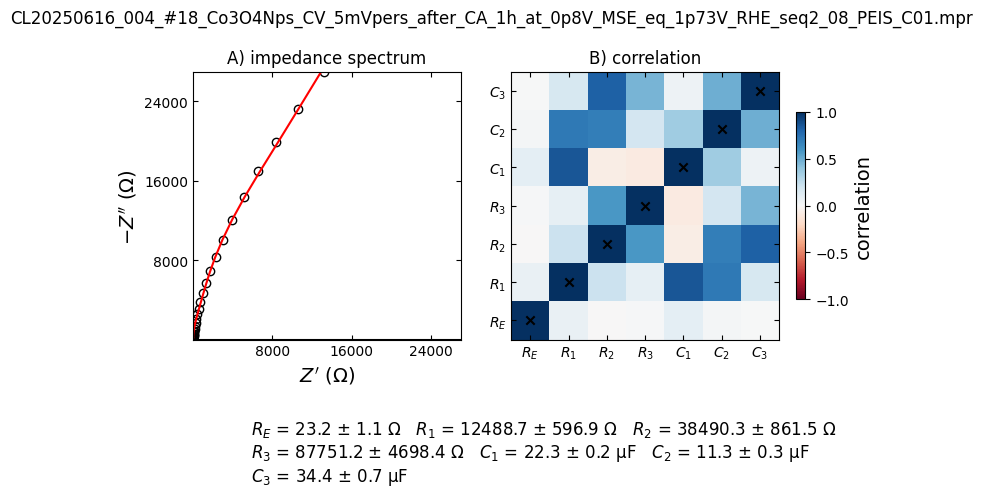

CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq2_11_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 23.3 ± 1.1 $\mathrm{\Omega}$   $R_1$ = 7449.4 ± 416.0 $\mathrm{\Omega}$   $R_2$ = 22022.1 ± 530.7 $\mathrm{\Omega}$   
$R_3$ = 46752.9 ± 1975.1 $\mathrm{\Omega}$   $C_1$ = 28.2 ± 0.3 $\mathrm{\mu F}$   $C_2$ = 16.2 ± 0.6 $\mathrm{\mu F}$   
$C_3$ = 52.4 ± 1.2 $\mathrm{\mu F}$   


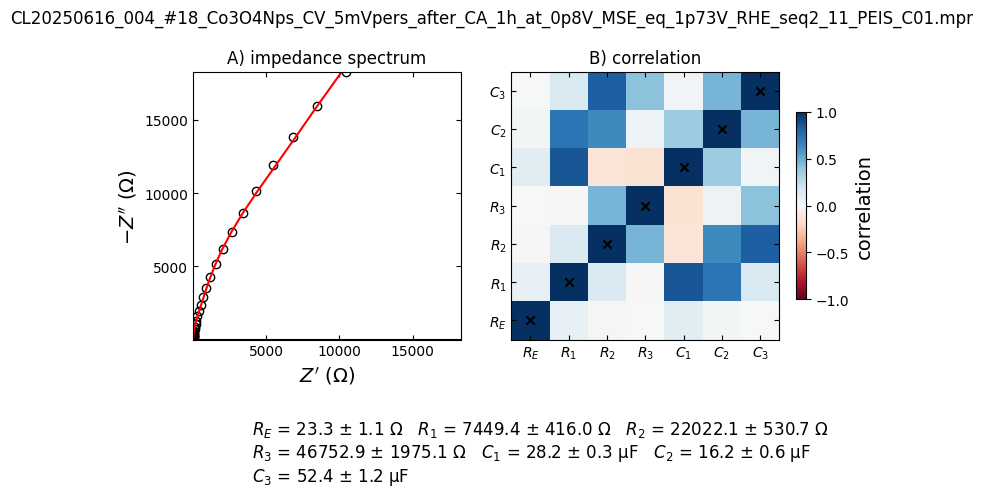

CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq2_14_PEIS_C01.mpr
---weight 0.3---
$R_E$ = 23.5 ± 1.1 $\mathrm{\Omega}$   $R_1$ = 7220.4 ± 407.4 $\mathrm{\Omega}$   $R_2$ = 19651.6 ± 403.7 $\mathrm{\Omega}$   
$R_3$ = 31808.6 ± 1227.4 $\mathrm{\Omega}$   $C_1$ = 25.7 ± 0.3 $\mathrm{\mu F}$   $C_2$ = 15.7 ± 0.6 $\mathrm{\mu F}$   
$C_3$ = 68.0 ± 1.8 $\mathrm{\mu F}$   


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


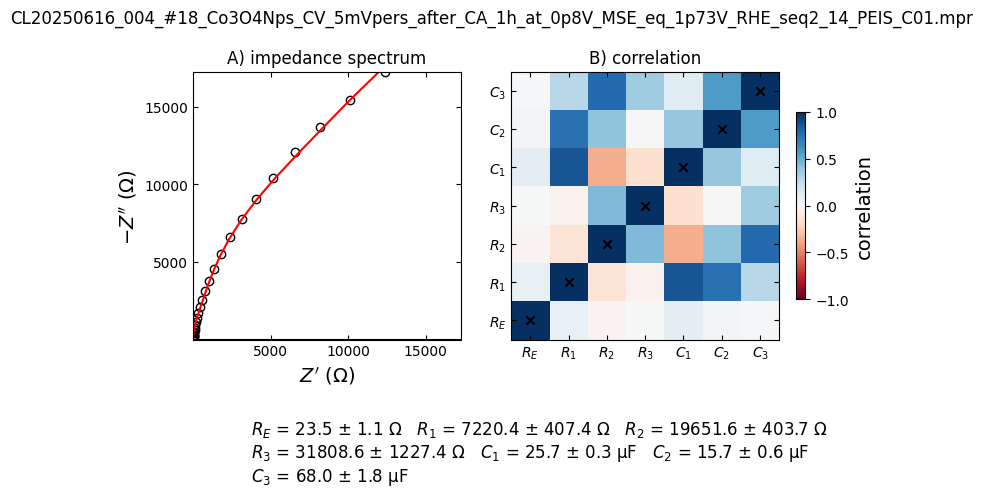

CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq2_17_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 23.8 ± 1.2 $\mathrm{\Omega}$   $R_1$ = 9236.0 ± 496.1 $\mathrm{\Omega}$   $R_2$ = 19346.3 ± 405.2 $\mathrm{\Omega}$   
$R_3$ = 23933.5 ± 944.6 $\mathrm{\Omega}$   $C_1$ = 22.5 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 14.5 ± 0.7 $\mathrm{\mu F}$   
$C_3$ = 82.4 ± 2.8 $\mathrm{\mu F}$   


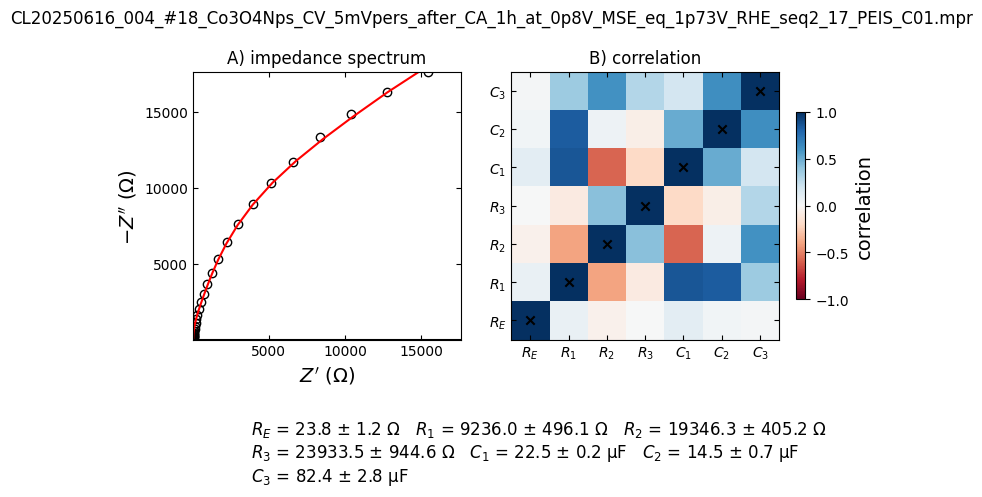

CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq2_20_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 23.9 ± 1.2 $\mathrm{\Omega}$   $R_1$ = 12261.8 ± 685.6 $\mathrm{\Omega}$   $R_2$ = 24061.8 ± 525.6 $\mathrm{\Omega}$   
$R_3$ = 36011.1 ± 1663.3 $\mathrm{\Omega}$   $C_1$ = 22.3 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 12.3 ± 0.6 $\mathrm{\mu F}$   
$C_3$ = 66.1 ± 1.9 $\mathrm{\mu F}$   


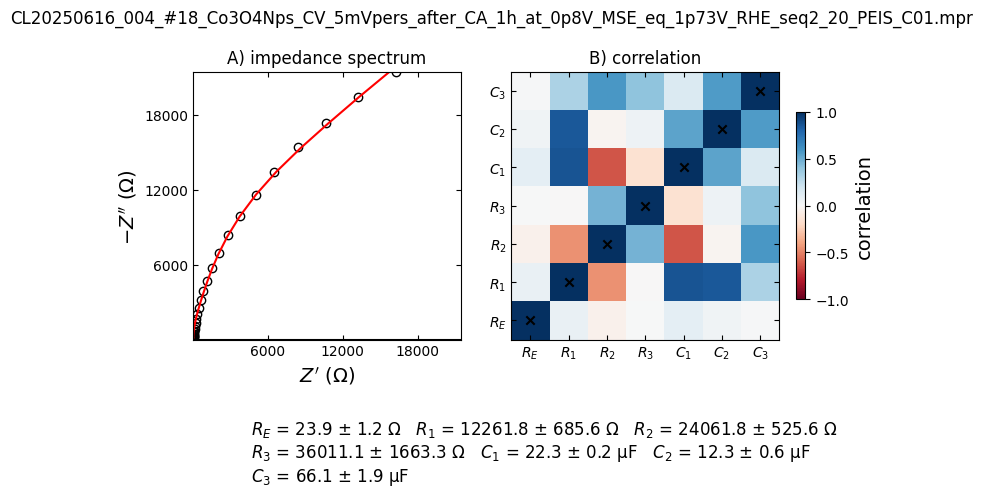

CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq3_03_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 24.1 ± 1.1 $\mathrm{\Omega}$   $R_1$ = 12452.8 ± 574.2 $\mathrm{\Omega}$   $R_2$ = 21758.9 ± 439.1 $\mathrm{\Omega}$   
$R_3$ = 27922.7 ± 1559.9 $\mathrm{\Omega}$   $C_1$ = 22.0 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 13.9 ± 0.6 $\mathrm{\mu F}$   
$C_3$ = 90.7 ± 2.9 $\mathrm{\mu F}$   


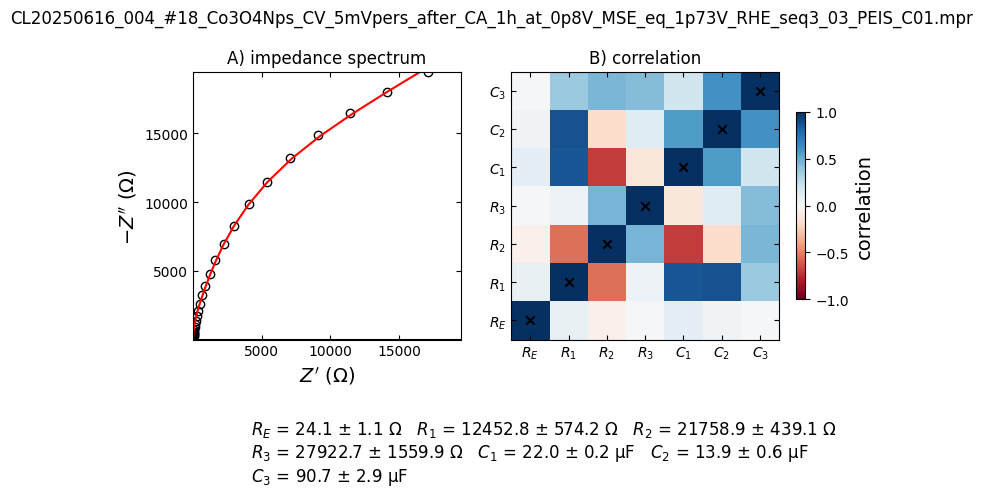

CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq3_06_PEIS_C01.mpr
---weight 0.3---
$R_E$ = 25.2 ± 1.2 $\mathrm{\Omega}$   $R_1$ = 13483.7 ± 698.1 $\mathrm{\Omega}$   $R_2$ = 20482.1 ± 506.0 $\mathrm{\Omega}$   
$R_3$ = 25100.3 ± 1221.4 $\mathrm{\Omega}$   $C_1$ = 21.6 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 13.5 ± 0.8 $\mathrm{\mu F}$   
$C_3$ = 87.5 ± 3.2 $\mathrm{\mu F}$   


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


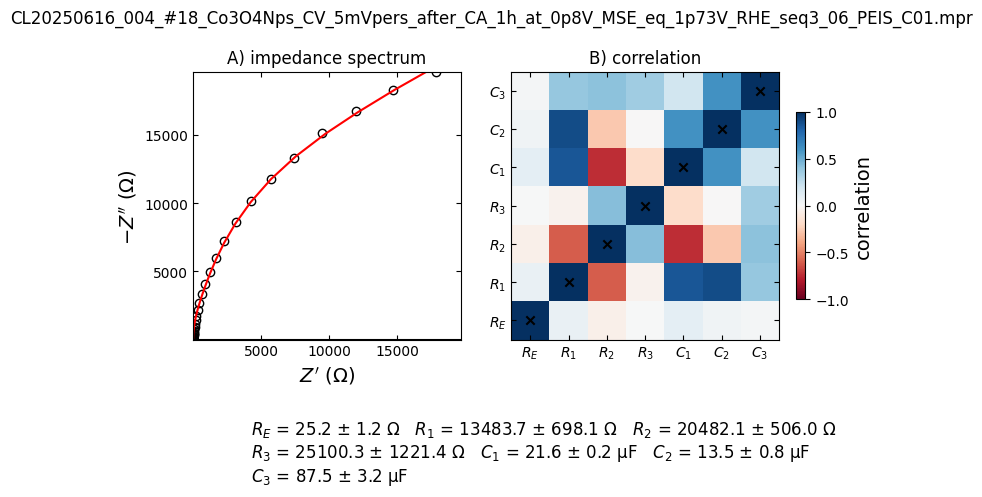

CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq3_09_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 25.0 ± 1.1 $\mathrm{\Omega}$   $R_1$ = 12958.2 ± 597.4 $\mathrm{\Omega}$   $R_2$ = 16668.6 ± 450.2 $\mathrm{\Omega}$   
$R_3$ = 14833.5 ± 857.6 $\mathrm{\Omega}$   $C_1$ = 21.8 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 15.0 ± 0.9 $\mathrm{\mu F}$   
$C_3$ = 147.7 ± 6.6 $\mathrm{\mu F}$   


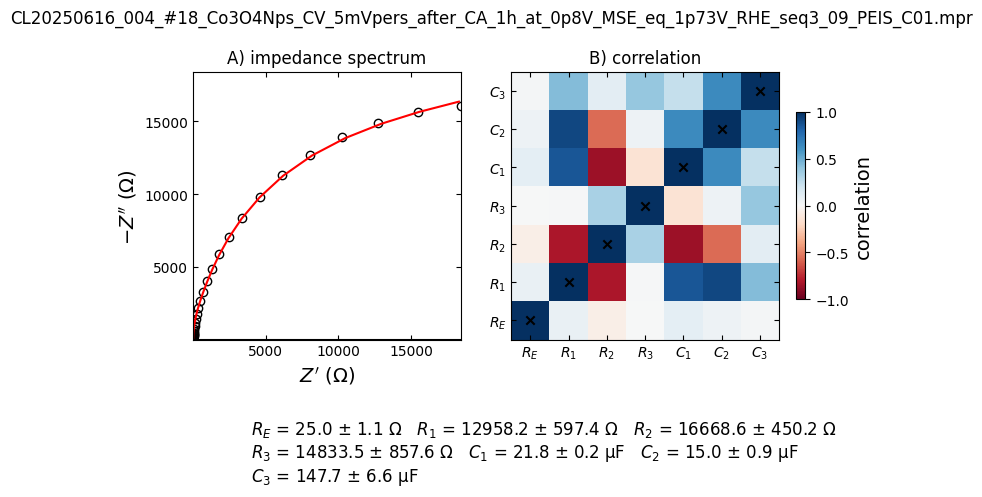

CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq3_12_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 24.8 ± 1.2 $\mathrm{\Omega}$   $R_1$ = 10582.2 ± 586.9 $\mathrm{\Omega}$   $R_2$ = 12171.8 ± 448.3 $\mathrm{\Omega}$   
$R_3$ = 6629.9 ± 290.6 $\mathrm{\Omega}$   $C_1$ = 22.1 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 15.8 ± 1.3 $\mathrm{\mu F}$   
$C_3$ = 192.6 ± 15.4 $\mathrm{\mu F}$   


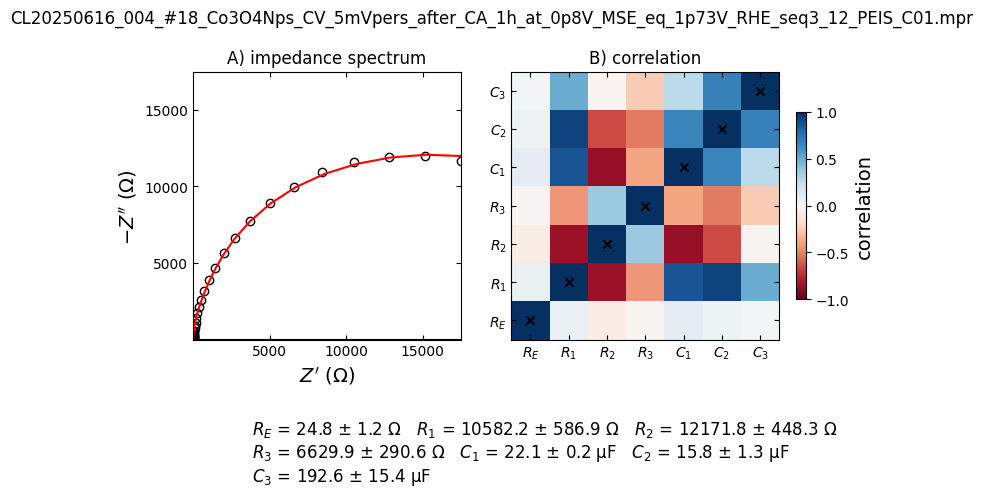

CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq3_15_PEIS_C01.mpr
---weight 0.3---


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


$R_E$ = 24.2 ± 0.9 $\mathrm{\Omega}$   $R_1$ = 5918.0 ± 586.1 $\mathrm{\Omega}$   $R_2$ = 9371.1 ± 472.4 $\mathrm{\Omega}$   
$R_3$ = 4275.7 ± 200.6 $\mathrm{\Omega}$   $C_1$ = 21.6 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 10.0 ± 1.0 $\mathrm{\mu F}$   
$C_3$ = 137.0 ± 11.3 $\mathrm{\mu F}$   


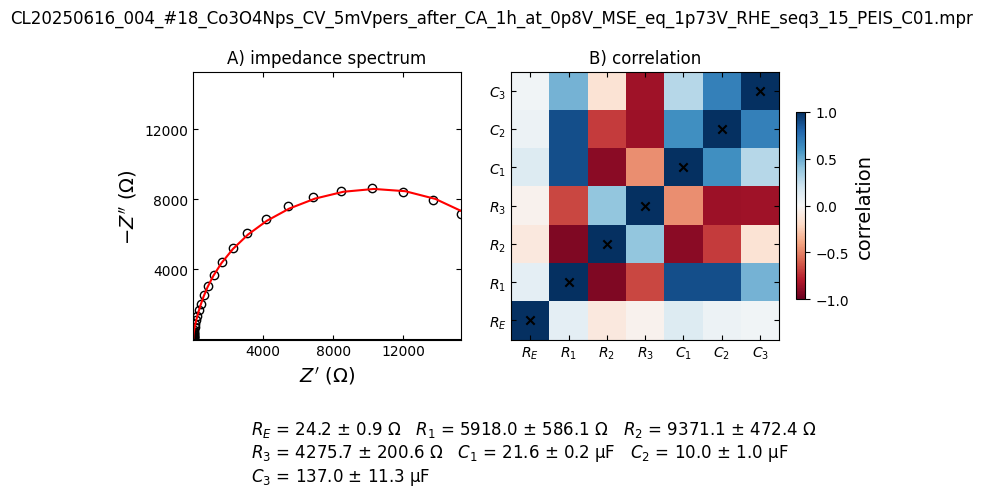

CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq3_18_PEIS_C01.mpr
---weight 0.3---
$R_E$ = 24.0 ± 1.0 $\mathrm{\Omega}$   $R_1$ = 4524.2 ± 501.5 $\mathrm{\Omega}$   $R_2$ = 6141.6 ± 413.8 $\mathrm{\Omega}$   
$R_3$ = 2673.3 ± 150.4 $\mathrm{\Omega}$   $C_1$ = 21.7 ± 0.3 $\mathrm{\mu F}$   $C_2$ = 11.4 ± 1.4 $\mathrm{\mu F}$   
$C_3$ = 178.1 ± 17.6 $\mathrm{\mu F}$   


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


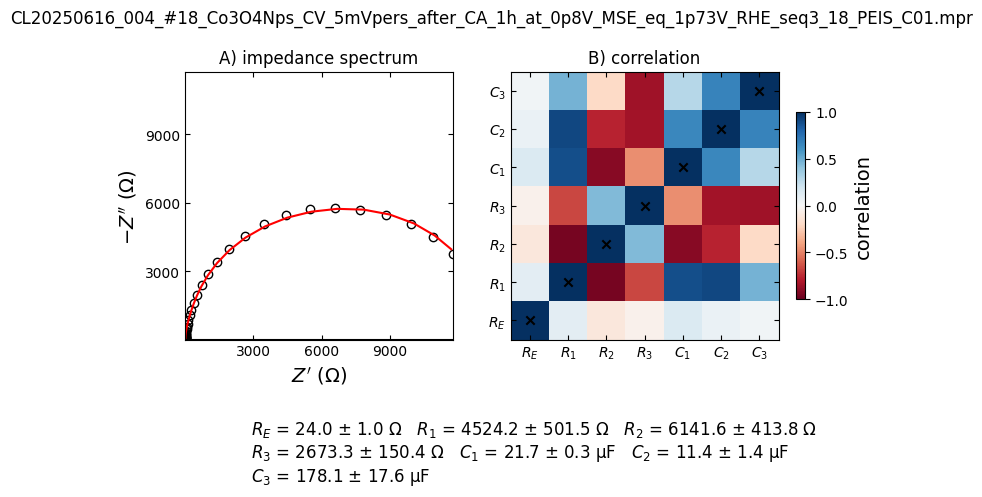

CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq4_03_PEIS_C01.mpr
---weight 0.3---
$R_E$ = 24.1 ± 1.0 $\mathrm{\Omega}$   $R_1$ = 3882.7 ± 380.3 $\mathrm{\Omega}$   $R_2$ = 3630.5 ± 316.1 $\mathrm{\Omega}$   
$R_3$ = 1494.0 ± 106.7 $\mathrm{\Omega}$   $C_1$ = 21.8 ± 0.3 $\mathrm{\mu F}$   $C_2$ = 16.1 ± 2.9 $\mathrm{\mu F}$   
$C_3$ = 289.7 ± 38.1 $\mathrm{\mu F}$   


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


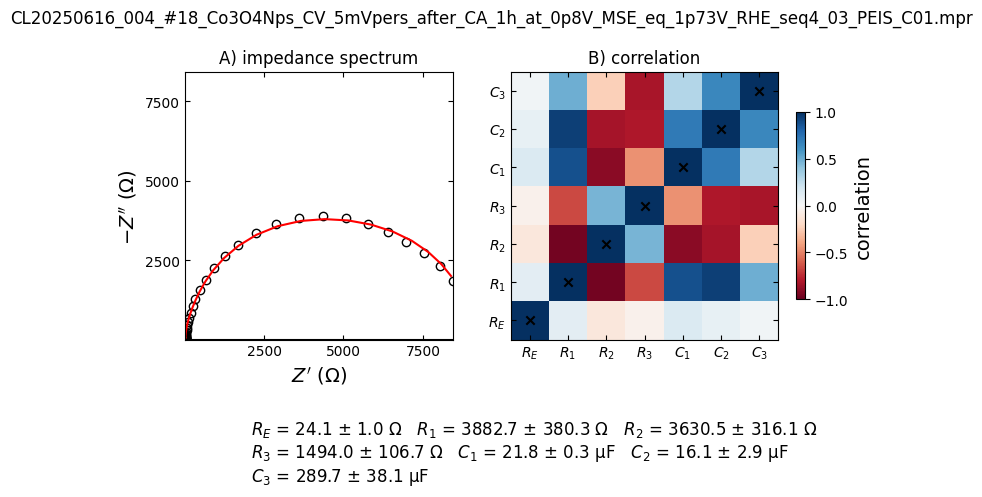

CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq4_06_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 23.9 ± 0.9 $\mathrm{\Omega}$   $R_1$ = 2976.2 ± 308.9 $\mathrm{\Omega}$   $R_2$ = 2457.0 ± 262.5 $\mathrm{\Omega}$   
$R_3$ = 915.1 ± 78.0 $\mathrm{\Omega}$   $C_1$ = 22.2 ± 0.3 $\mathrm{\mu F}$   $C_2$ = 18.1 ± 3.9 $\mathrm{\mu F}$   
$C_3$ = 385.9 ± 62.5 $\mathrm{\mu F}$   


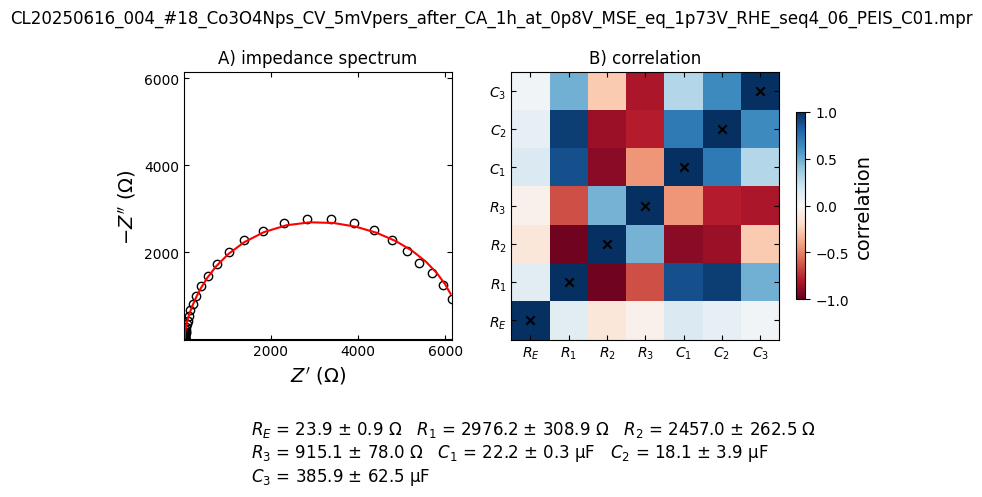

CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq4_09_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 23.8 ± 0.8 $\mathrm{\Omega}$   $R_1$ = 1978.1 ± 270.0 $\mathrm{\Omega}$   $R_2$ = 1797.6 ± 232.3 $\mathrm{\Omega}$   
$R_3$ = 618.3 ± 64.5 $\mathrm{\Omega}$   $C_1$ = 21.9 ± 0.4 $\mathrm{\mu F}$   $C_2$ = 15.6 ± 3.9 $\mathrm{\mu F}$   
$C_3$ = 351.5 ± 67.8 $\mathrm{\mu F}$   


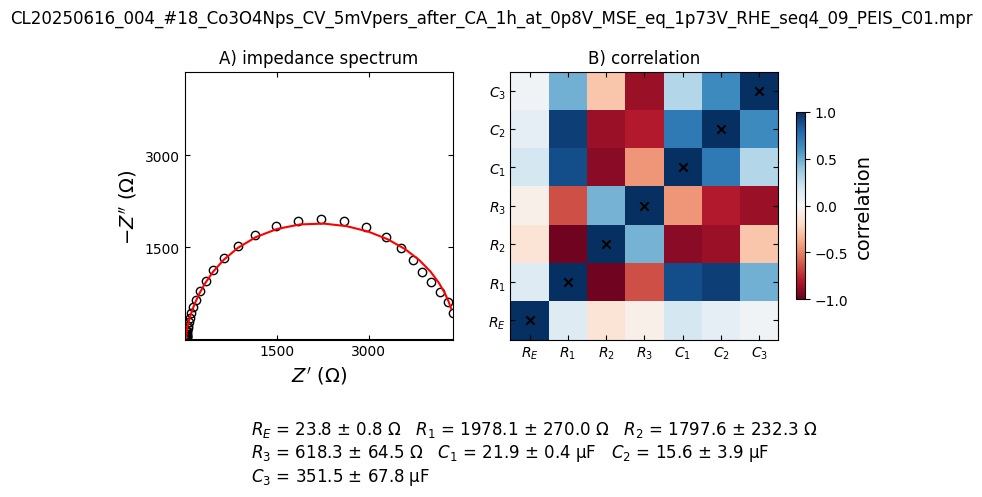

CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq4_12_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 23.8 ± 0.7 $\mathrm{\Omega}$   $R_1$ = 1638.6 ± 176.6 $\mathrm{\Omega}$   $R_2$ = 1143.0 ± 150.4 $\mathrm{\Omega}$   
$R_3$ = 337.6 ± 46.1 $\mathrm{\Omega}$   $C_1$ = 22.2 ± 0.4 $\mathrm{\mu F}$   $C_2$ = 21.9 ± 6.0 $\mathrm{\mu F}$   
$C_3$ = 545.6 ± 144.5 $\mathrm{\mu F}$   


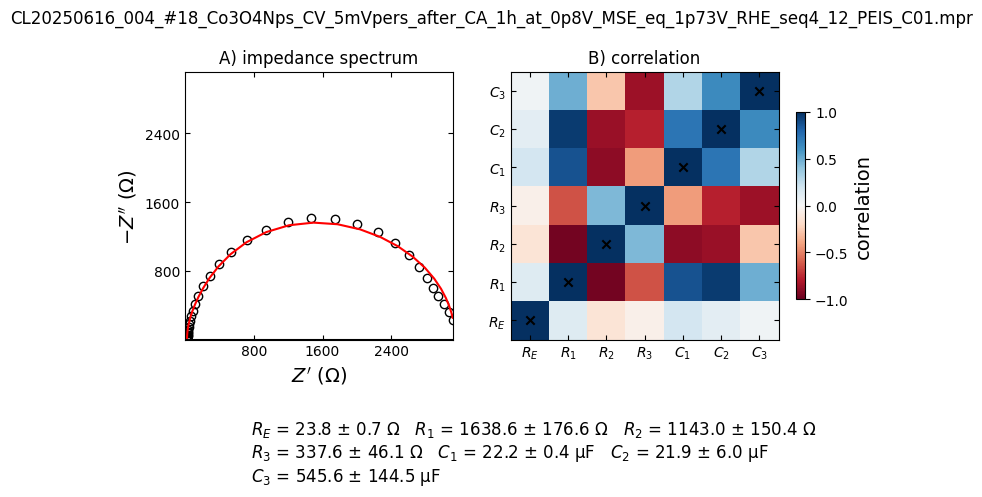

CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq4_15_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 23.4 ± 0.4 $\mathrm{\Omega}$   $R_1$ = 328.4 ± 95.6 $\mathrm{\Omega}$   $R_2$ = 823.8 ± 84.8 $\mathrm{\Omega}$   
$R_3$ = 221.2 ± 25.5 $\mathrm{\Omega}$   $C_1$ = 19.8 ± 0.8 $\mathrm{\mu F}$   $C_2$ = 8.3 ± 1.2 $\mathrm{\mu F}$   
$C_3$ = 210.3 ± 45.7 $\mathrm{\mu F}$   


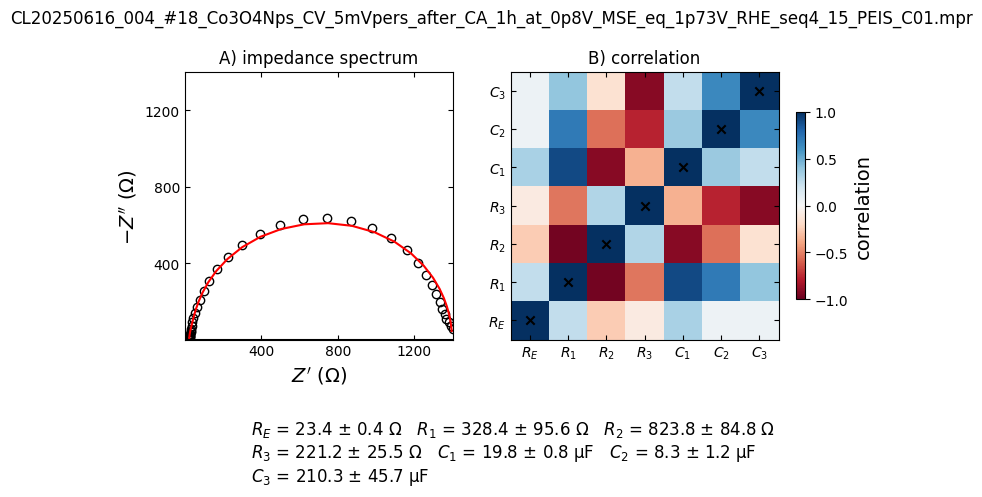

CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq4_18_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 20.7 ± 0.3 $\mathrm{\Omega}$   $R_1$ = 150.7 ± 36.2 $\mathrm{\Omega}$   $R_2$ = 371.4 ± 32.2 $\mathrm{\Omega}$   
$R_3$ = 95.4 ± 10.1 $\mathrm{\Omega}$   $C_1$ = 21.2 ± 0.8 $\mathrm{\mu F}$   $C_2$ = 10.2 ± 1.2 $\mathrm{\mu F}$   
$C_3$ = 272.5 ± 56.6 $\mathrm{\mu F}$   


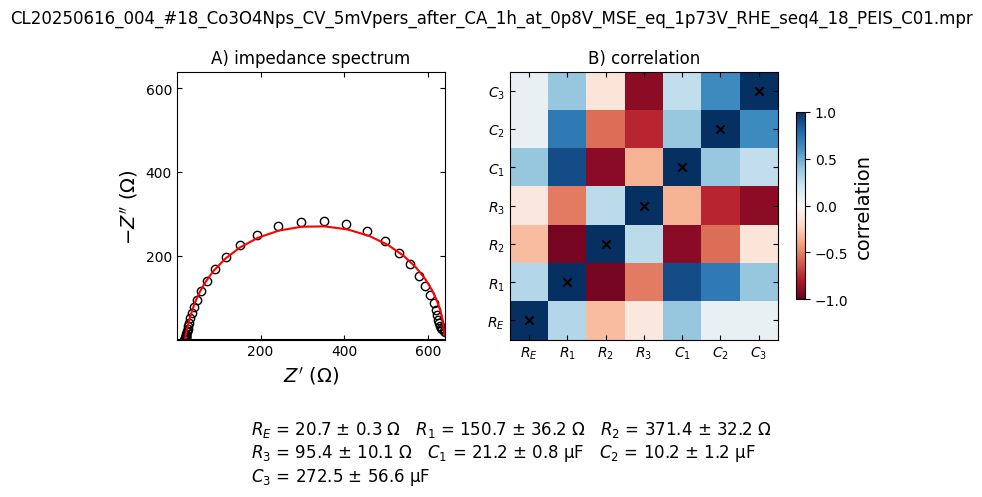

CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq5_03_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 20.8 ± 0.2 $\mathrm{\Omega}$   $R_1$ = 99.3 ± 16.2 $\mathrm{\Omega}$   $R_2$ = 161.0 ± 13.7 $\mathrm{\Omega}$   
$R_3$ = 38.8 ± 5.9 $\mathrm{\Omega}$   $C_1$ = 20.2 ± 0.6 $\mathrm{\mu F}$   $C_2$ = 13.5 ± 2.1 $\mathrm{\mu F}$   
$C_3$ = 309.4 ± 88.5 $\mathrm{\mu F}$   


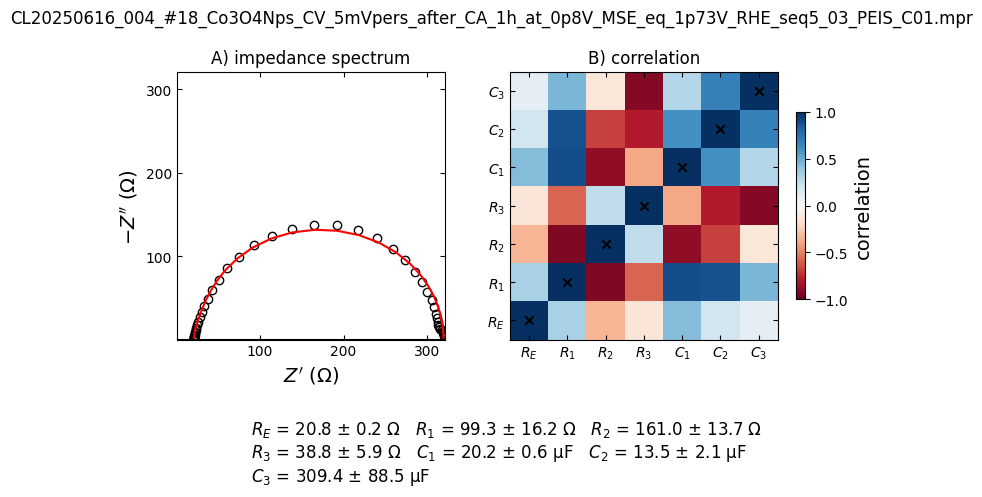

CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq5_06_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 21.0 ± 0.1 $\mathrm{\Omega}$   $R_1$ = 80.0 ± 10.6 $\mathrm{\Omega}$   $R_2$ = 96.3 ± 8.6 $\mathrm{\Omega}$   
$R_3$ = 22.7 ± 4.5 $\mathrm{\Omega}$   $C_1$ = 20.3 ± 0.5 $\mathrm{\mu F}$   $C_2$ = 17.2 ± 3.3 $\mathrm{\mu F}$   
$C_3$ = 357.1 ± 131.8 $\mathrm{\mu F}$   


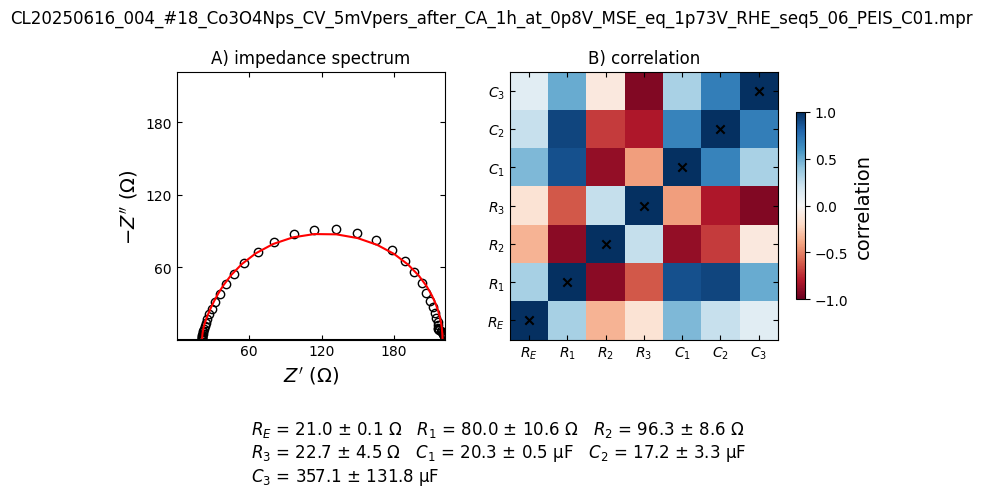

CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq2_02_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 24.4 ± 1.1 $\mathrm{\Omega}$   $R_1$ = 18906.6 ± 1061.7 $\mathrm{\Omega}$   $R_2$ = 51780.1 ± 1463.7 $\mathrm{\Omega}$   
$R_3$ = 153708.6 ± 7782.0 $\mathrm{\Omega}$   $C_1$ = 21.9 ± 0.1 $\mathrm{\mu F}$   $C_2$ = 8.2 ± 0.3 $\mathrm{\mu F}$   
$C_3$ = 20.8 ± 0.3 $\mathrm{\mu F}$   


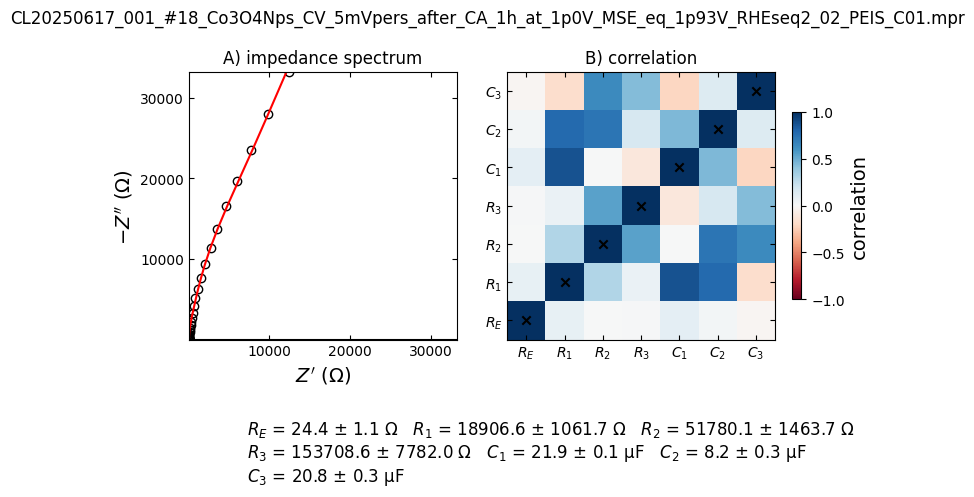

CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq2_05_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 24.8 ± 1.1 $\mathrm{\Omega}$   $R_1$ = 20282.7 ± 1448.3 $\mathrm{\Omega}$   $R_2$ = 65369.7 ± 2325.7 $\mathrm{\Omega}$   
$R_3$ = 250613.4 ± 12652.5 $\mathrm{\Omega}$   $C_1$ = 21.1 ± 0.1 $\mathrm{\mu F}$   $C_2$ = 6.4 ± 0.3 $\mathrm{\mu F}$   
$C_3$ = 13.3 ± 0.2 $\mathrm{\mu F}$   


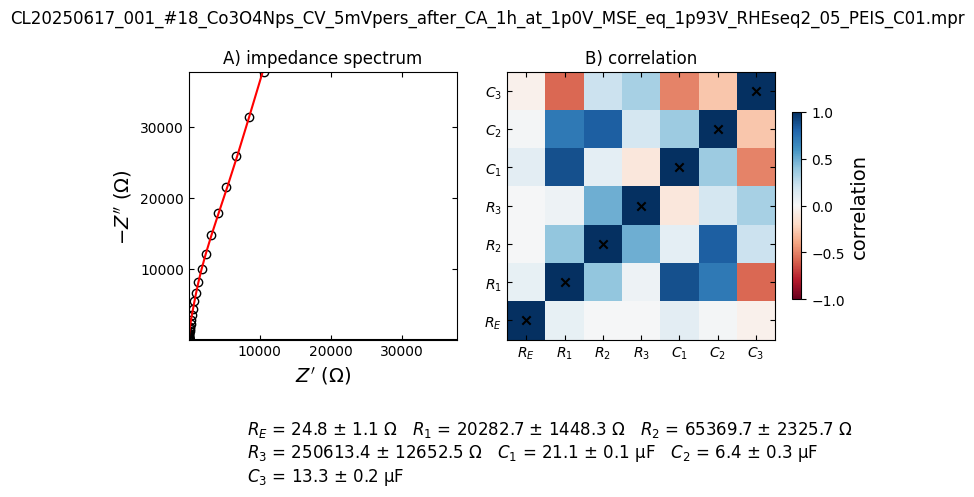

CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq2_08_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 24.9 ± 1.1 $\mathrm{\Omega}$   $R_1$ = 11806.1 ± 668.6 $\mathrm{\Omega}$   $R_2$ = 32321.8 ± 742.9 $\mathrm{\Omega}$   
$R_3$ = 75384.4 ± 3728.7 $\mathrm{\Omega}$   $C_1$ = 24.1 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 11.5 ± 0.4 $\mathrm{\mu F}$   
$C_3$ = 38.2 ± 0.8 $\mathrm{\mu F}$   


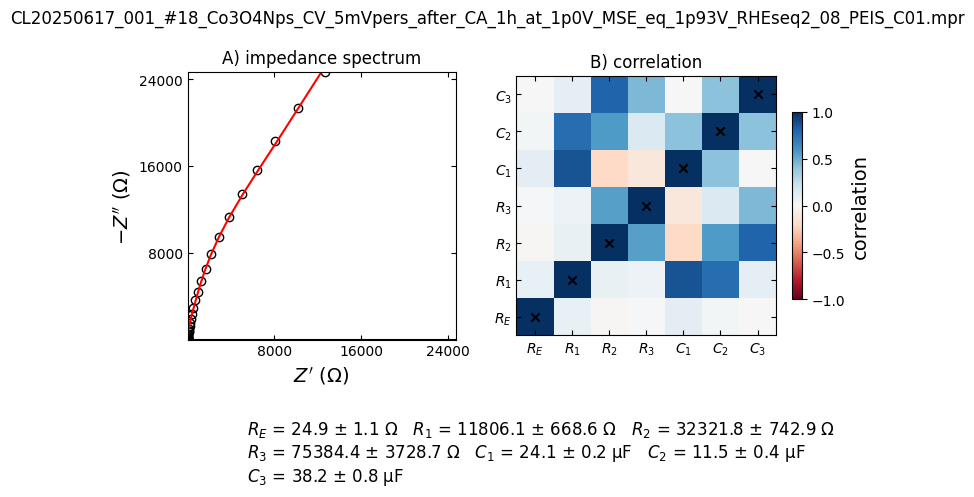

CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq2_11_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 24.9 ± 1.1 $\mathrm{\Omega}$   $R_1$ = 7462.6 ± 390.9 $\mathrm{\Omega}$   $R_2$ = 21379.2 ± 468.3 $\mathrm{\Omega}$   
$R_3$ = 39063.7 ± 1696.2 $\mathrm{\Omega}$   $C_1$ = 27.4 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 16.7 ± 0.6 $\mathrm{\mu F}$   
$C_3$ = 61.0 ± 1.5 $\mathrm{\mu F}$   


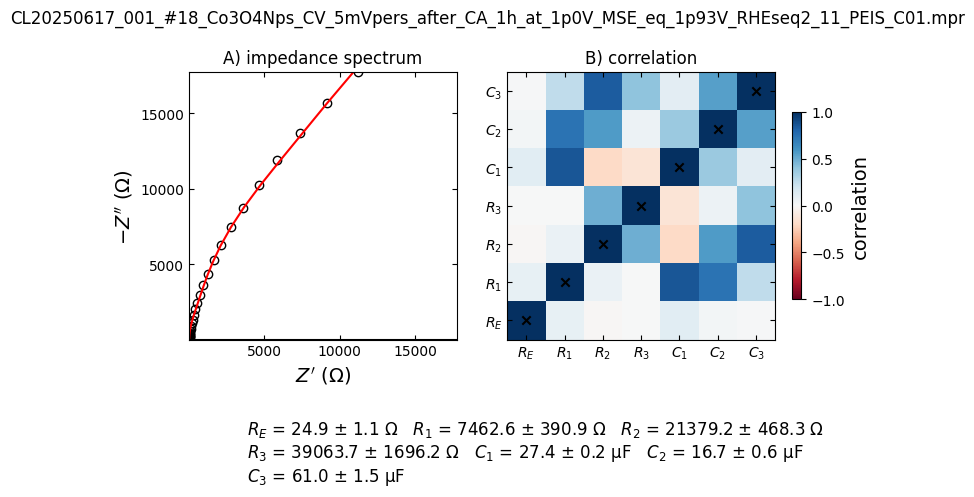

CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq2_14_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 25.3 ± 1.1 $\mathrm{\Omega}$   $R_1$ = 7788.0 ± 379.9 $\mathrm{\Omega}$   $R_2$ = 19971.6 ± 435.0 $\mathrm{\Omega}$   
$R_3$ = 34641.2 ± 1603.4 $\mathrm{\Omega}$   $C_1$ = 26.4 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 17.7 ± 0.6 $\mathrm{\mu F}$   
$C_3$ = 68.7 ± 1.9 $\mathrm{\mu F}$   


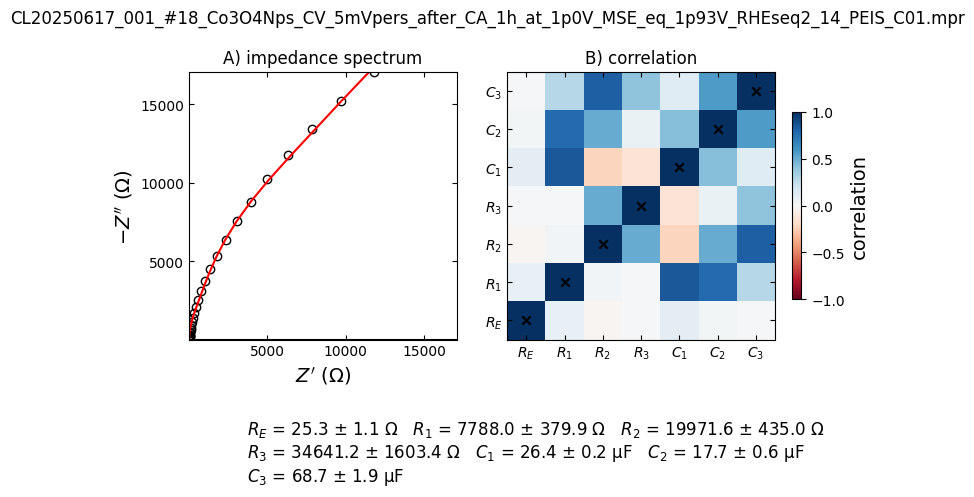

CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq2_17_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 25.3 ± 1.3 $\mathrm{\Omega}$   $R_1$ = 8721.1 ± 662.3 $\mathrm{\Omega}$   $R_2$ = 21368.8 ± 514.4 $\mathrm{\Omega}$   
$R_3$ = 36755.7 ± 1241.5 $\mathrm{\Omega}$   $C_1$ = 22.2 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 11.5 ± 0.6 $\mathrm{\mu F}$   
$C_3$ = 55.3 ± 1.4 $\mathrm{\mu F}$   


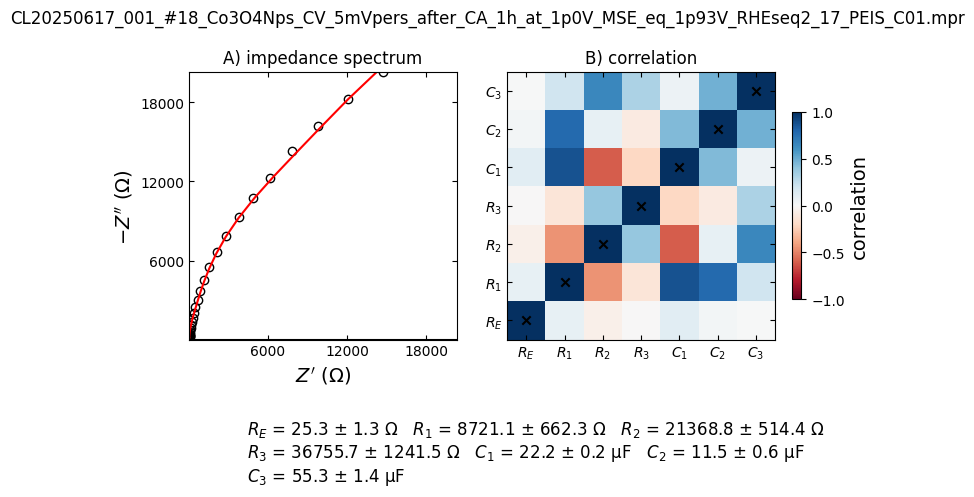

CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq2_20_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 25.6 ± 1.3 $\mathrm{\Omega}$   $R_1$ = 13731.1 ± 729.8 $\mathrm{\Omega}$   $R_2$ = 24767.1 ± 607.7 $\mathrm{\Omega}$   
$R_3$ = 45230.0 ± 2384.3 $\mathrm{\Omega}$   $C_1$ = 22.3 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 13.3 ± 0.7 $\mathrm{\mu F}$   
$C_3$ = 56.6 ± 1.6 $\mathrm{\mu F}$   


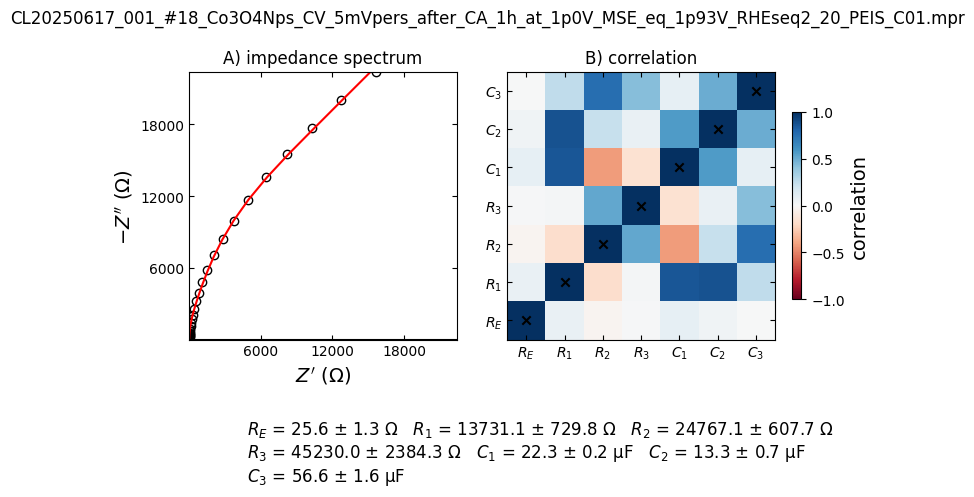

CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq3_03_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 25.4 ± 1.2 $\mathrm{\Omega}$   $R_1$ = 12883.4 ± 609.3 $\mathrm{\Omega}$   $R_2$ = 23080.0 ± 475.0 $\mathrm{\Omega}$   
$R_3$ = 30141.3 ± 1755.3 $\mathrm{\Omega}$   $C_1$ = 22.2 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 13.7 ± 0.6 $\mathrm{\mu F}$   
$C_3$ = 84.4 ± 2.8 $\mathrm{\mu F}$   


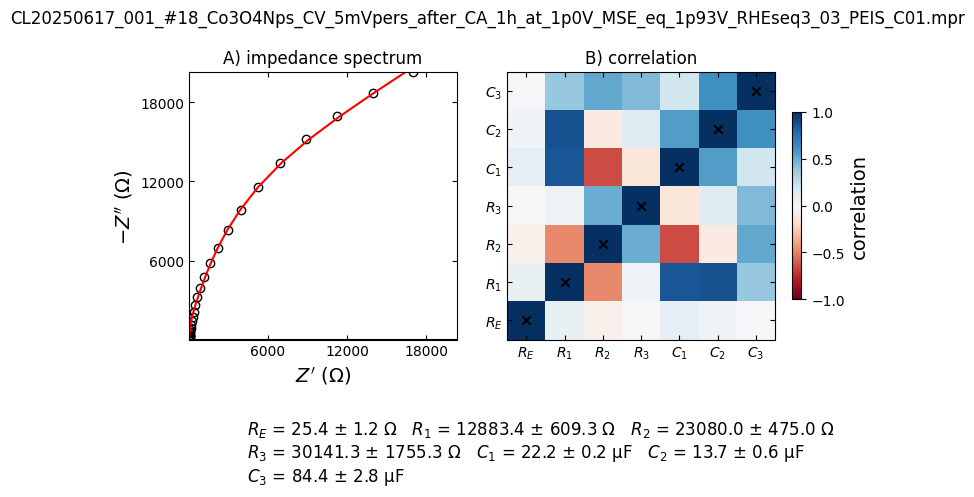

CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq3_06_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 25.4 ± 1.3 $\mathrm{\Omega}$   $R_1$ = 11464.3 ± 728.0 $\mathrm{\Omega}$   $R_2$ = 18288.2 ± 527.3 $\mathrm{\Omega}$   
$R_3$ = 20955.0 ± 870.8 $\mathrm{\Omega}$   $C_1$ = 22.2 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 12.9 ± 0.9 $\mathrm{\mu F}$   
$C_3$ = 92.4 ± 3.5 $\mathrm{\mu F}$   


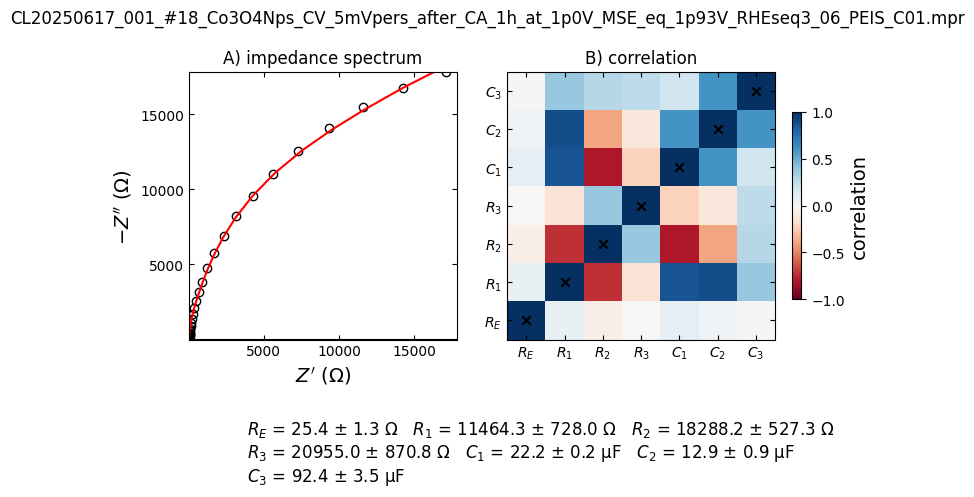

CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq3_09_PEIS_C01.mpr
---weight 0.3---
$R_E$ = 25.2 ± 1.2 $\mathrm{\Omega}$   $R_1$ = 9561.6 ± 622.2 $\mathrm{\Omega}$   $R_2$ = 14574.1 ± 476.0 $\mathrm{\Omega}$   
$R_3$ = 10561.2 ± 380.2 $\mathrm{\Omega}$   $C_1$ = 22.3 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 13.3 ± 0.9 $\mathrm{\mu F}$   
$C_3$ = 136.9 ± 7.4 $\mathrm{\mu F}$   


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


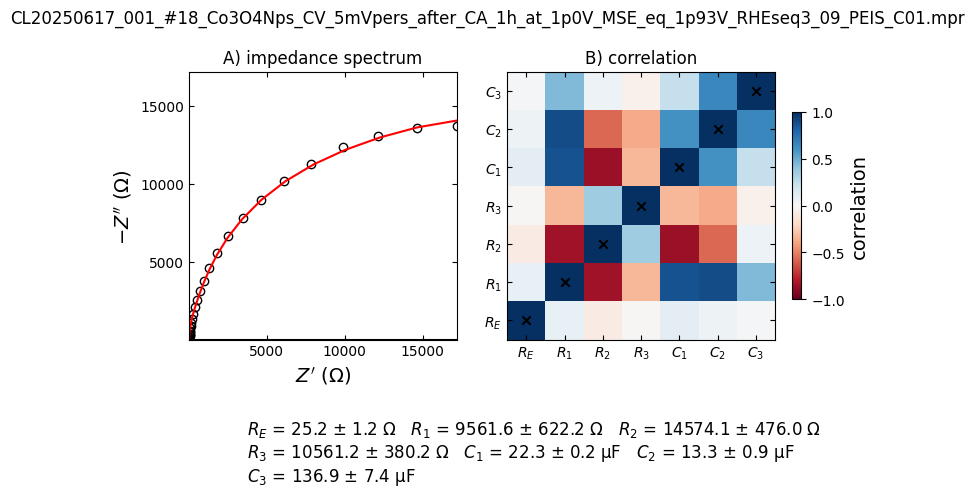

CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq3_12_PEIS_C01.mpr
---weight 0.3---
$R_E$ = 24.8 ± 1.0 $\mathrm{\Omega}$   $R_1$ = 6465.0 ± 539.2 $\mathrm{\Omega}$   $R_2$ = 10713.5 ± 427.2 $\mathrm{\Omega}$   
$R_3$ = 4850.0 ± 211.4 $\mathrm{\Omega}$   $C_1$ = 22.0 ± 0.2 $\mathrm{\mu F}$   $C_2$ = 11.2 ± 0.9 $\mathrm{\mu F}$   
$C_3$ = 145.4 ± 11.8 $\mathrm{\mu F}$   


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


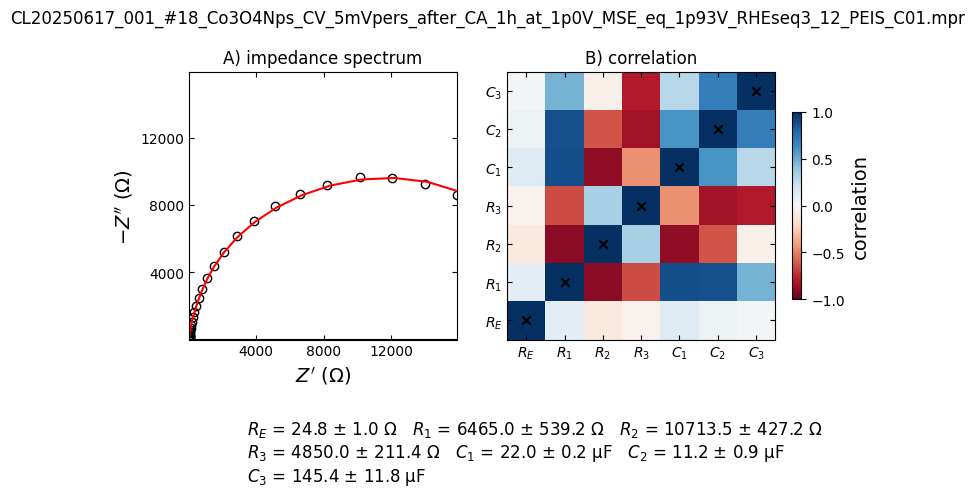

CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq3_15_PEIS_C01.mpr
---weight 0.3---
$R_E$ = 24.7 ± 1.0 $\mathrm{\Omega}$   $R_1$ = 5040.9 ± 474.3 $\mathrm{\Omega}$   $R_2$ = 7252.6 ± 368.9 $\mathrm{\Omega}$   
$R_3$ = 3586.4 ± 188.2 $\mathrm{\Omega}$   $C_1$ = 22.1 ± 0.3 $\mathrm{\mu F}$   $C_2$ = 11.8 ± 1.2 $\mathrm{\mu F}$   
$C_3$ = 139.7 ± 12.1 $\mathrm{\mu F}$   


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


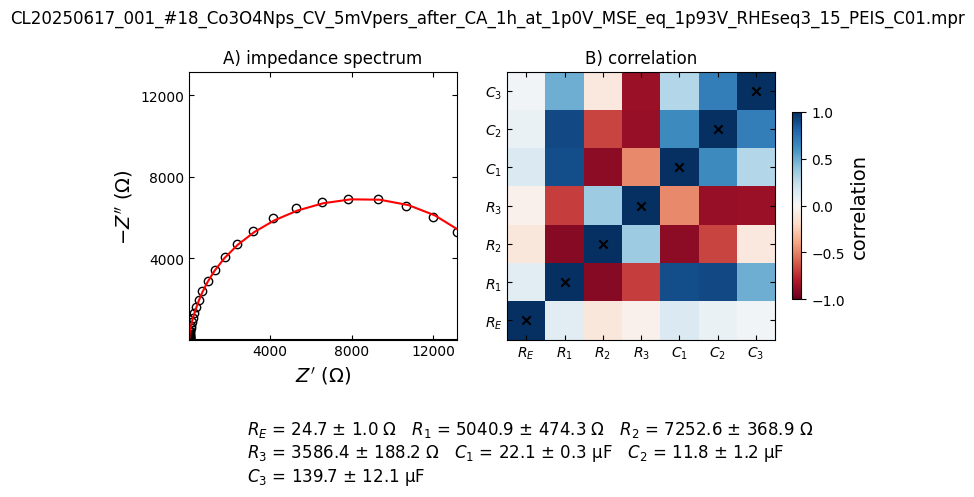

CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq3_18_PEIS_C01.mpr
---weight 0.3---
$R_E$ = 24.6 ± 1.0 $\mathrm{\Omega}$   $R_1$ = 3852.9 ± 432.4 $\mathrm{\Omega}$   $R_2$ = 4962.9 ± 348.4 $\mathrm{\Omega}$   
$R_3$ = 2407.3 ± 142.6 $\mathrm{\Omega}$   $C_1$ = 22.2 ± 0.3 $\mathrm{\mu F}$   $C_2$ = 12.4 ± 1.7 $\mathrm{\mu F}$   
$C_3$ = 171.2 ± 16.9 $\mathrm{\mu F}$   


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


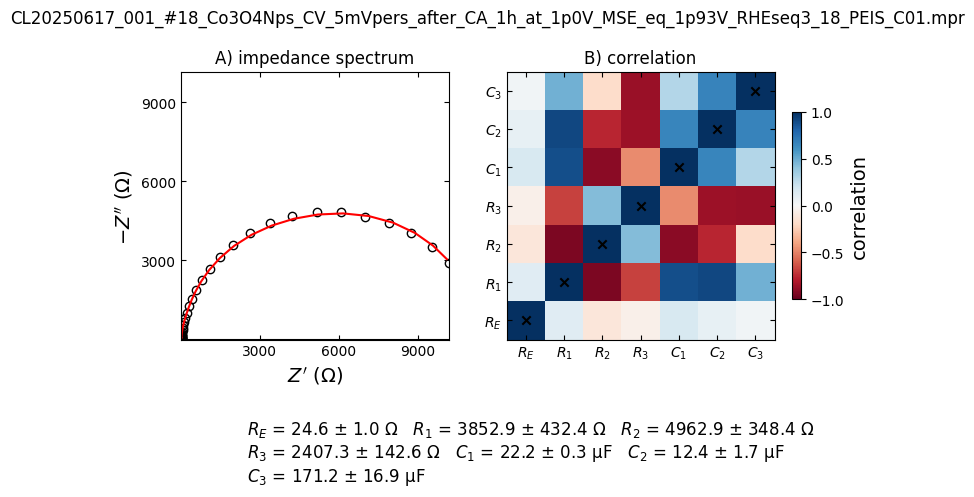

CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq4_03_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 24.3 ± 0.9 $\mathrm{\Omega}$   $R_1$ = 3302.1 ± 306.7 $\mathrm{\Omega}$   $R_2$ = 3052.5 ± 254.9 $\mathrm{\Omega}$   
$R_3$ = 1308.3 ± 88.0 $\mathrm{\Omega}$   $C_1$ = 22.0 ± 0.3 $\mathrm{\mu F}$   $C_2$ = 17.7 ± 3.0 $\mathrm{\mu F}$   
$C_3$ = 317.4 ± 39.8 $\mathrm{\mu F}$   


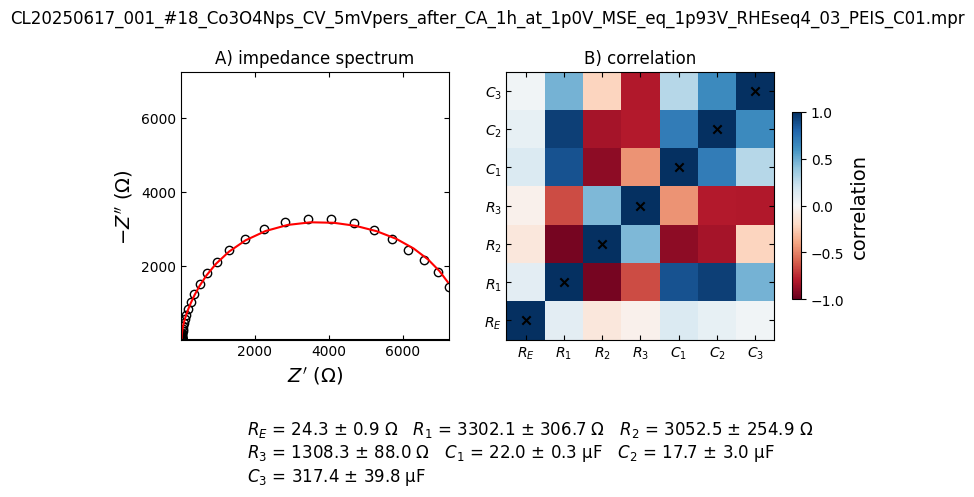

CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq4_06_PEIS_C01.mpr
---weight 0.3---
$R_E$ = 24.3 ± 0.9 $\mathrm{\Omega}$   $R_1$ = 2388.0 ± 280.8 $\mathrm{\Omega}$   $R_2$ = 2246.1 ± 236.3 $\mathrm{\Omega}$   
$R_3$ = 874.4 ± 75.7 $\mathrm{\Omega}$   $C_1$ = 22.1 ± 0.4 $\mathrm{\mu F}$   $C_2$ = 16.4 ± 3.4 $\mathrm{\mu F}$   
$C_3$ = 315.2 ± 49.7 $\mathrm{\mu F}$   


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


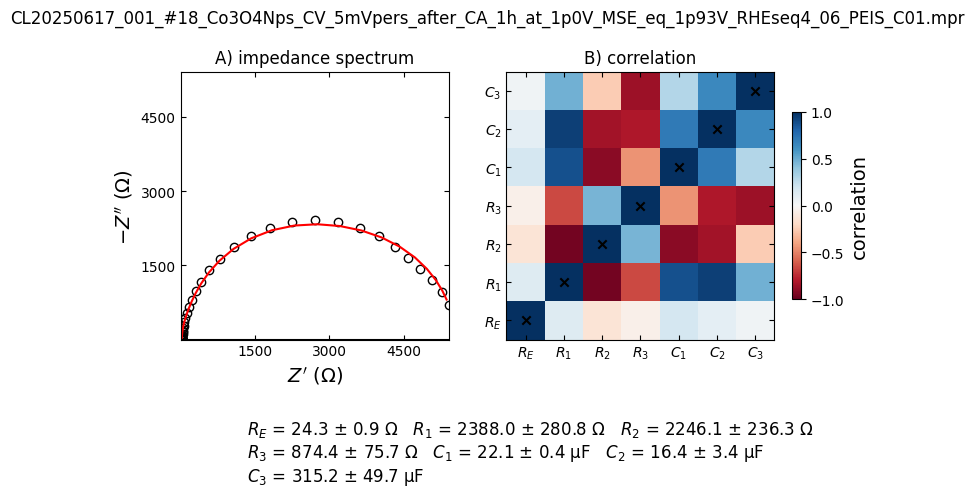

CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq4_09_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 24.4 ± 0.8 $\mathrm{\Omega}$   $R_1$ = 1875.4 ± 212.4 $\mathrm{\Omega}$   $R_2$ = 1581.2 ± 182.8 $\mathrm{\Omega}$   
$R_3$ = 543.9 ± 52.0 $\mathrm{\Omega}$   $C_1$ = 22.3 ± 0.4 $\mathrm{\mu F}$   $C_2$ = 18.6 ± 4.3 $\mathrm{\mu F}$   
$C_3$ = 439.1 ± 81.0 $\mathrm{\mu F}$   


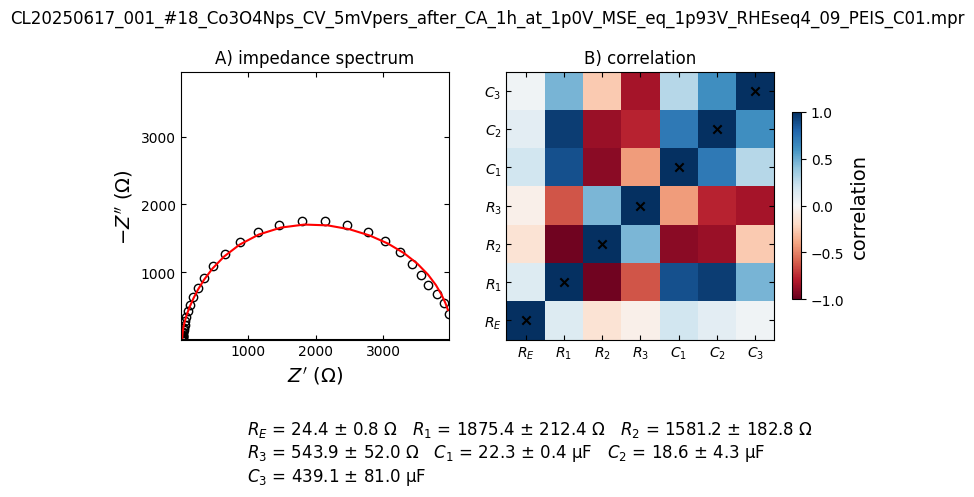

CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq4_12_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 24.3 ± 0.7 $\mathrm{\Omega}$   $R_1$ = 1477.7 ± 155.4 $\mathrm{\Omega}$   $R_2$ = 1135.6 ± 133.4 $\mathrm{\Omega}$   
$R_3$ = 336.0 ± 39.9 $\mathrm{\Omega}$   $C_1$ = 22.3 ± 0.4 $\mathrm{\mu F}$   $C_2$ = 21.2 ± 5.1 $\mathrm{\mu F}$   
$C_3$ = 550.0 ± 129.3 $\mathrm{\mu F}$   


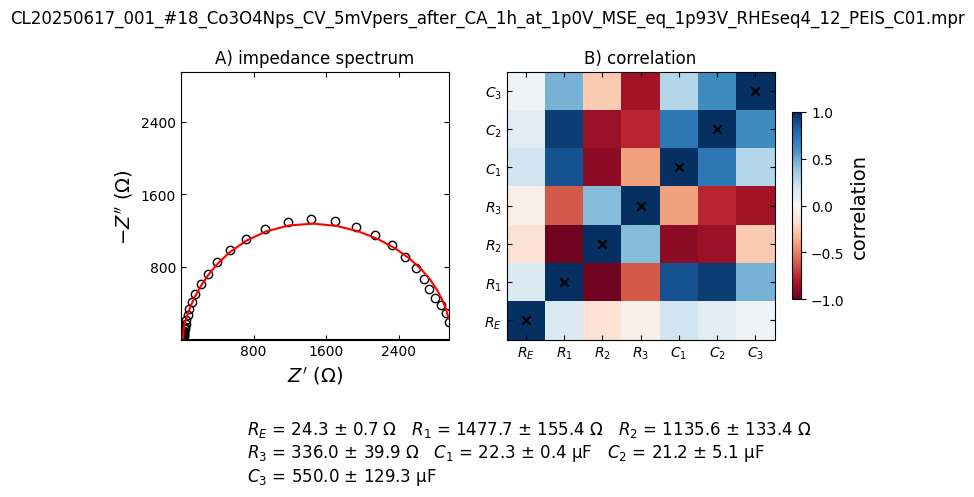

CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq4_15_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 23.7 ± 0.5 $\mathrm{\Omega}$   $R_1$ = 319.8 ± 96.8 $\mathrm{\Omega}$   $R_2$ = 850.8 ± 86.1 $\mathrm{\Omega}$   
$R_3$ = 240.9 ± 25.2 $\mathrm{\Omega}$   $C_1$ = 20.1 ± 0.8 $\mathrm{\mu F}$   $C_2$ = 8.3 ± 1.1 $\mathrm{\mu F}$   
$C_3$ = 205.5 ± 40.7 $\mathrm{\mu F}$   


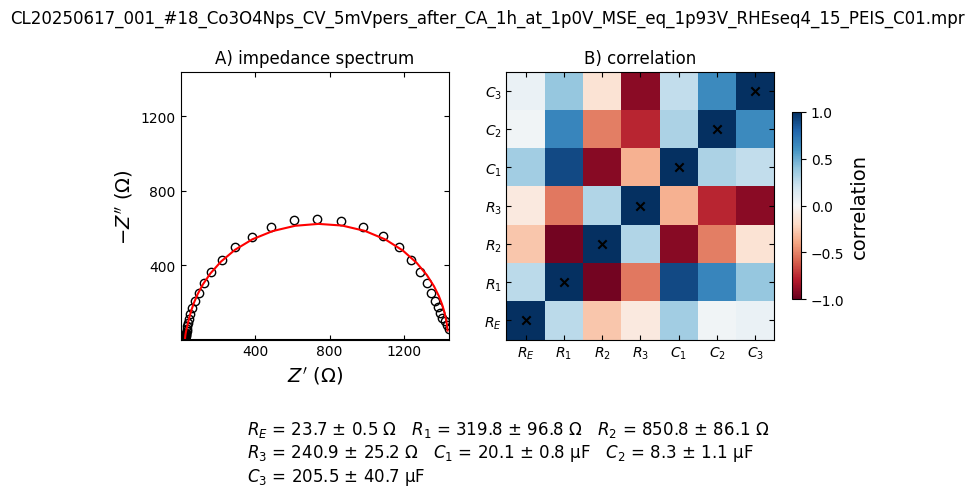

CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq4_18_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 21.2 ± 0.3 $\mathrm{\Omega}$   $R_1$ = 183.3 ± 41.5 $\mathrm{\Omega}$   $R_2$ = 383.6 ± 36.6 $\mathrm{\Omega}$   
$R_3$ = 106.9 ± 11.3 $\mathrm{\Omega}$   $C_1$ = 22.3 ± 0.8 $\mathrm{\mu F}$   $C_2$ = 11.3 ± 1.6 $\mathrm{\mu F}$   
$C_3$ = 283.5 ± 57.6 $\mathrm{\mu F}$   


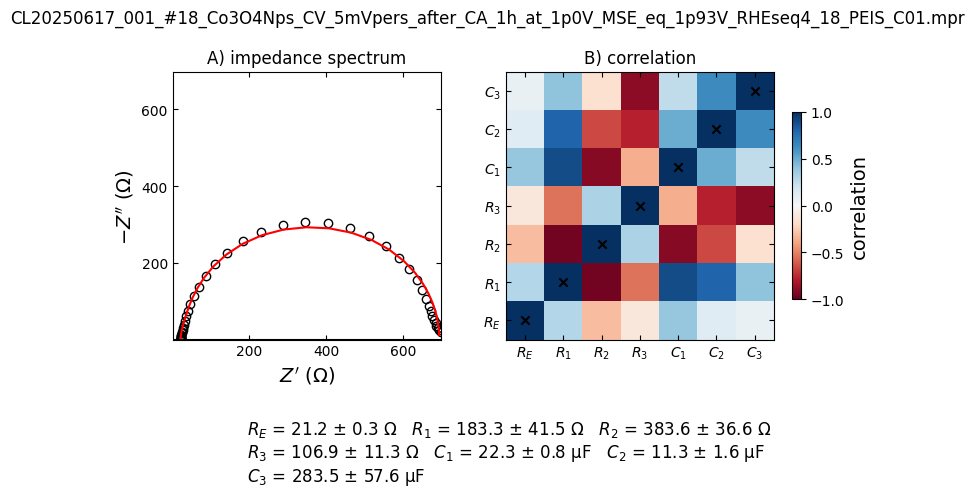

CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq5_03_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 21.2 ± 0.2 $\mathrm{\Omega}$   $R_1$ = 121.1 ± 20.3 $\mathrm{\Omega}$   $R_2$ = 208.5 ± 17.7 $\mathrm{\Omega}$   
$R_3$ = 53.2 ± 6.0 $\mathrm{\Omega}$   $C_1$ = 21.5 ± 0.6 $\mathrm{\mu F}$   $C_2$ = 13.6 ± 1.9 $\mathrm{\mu F}$   
$C_3$ = 358.5 ± 80.4 $\mathrm{\mu F}$   


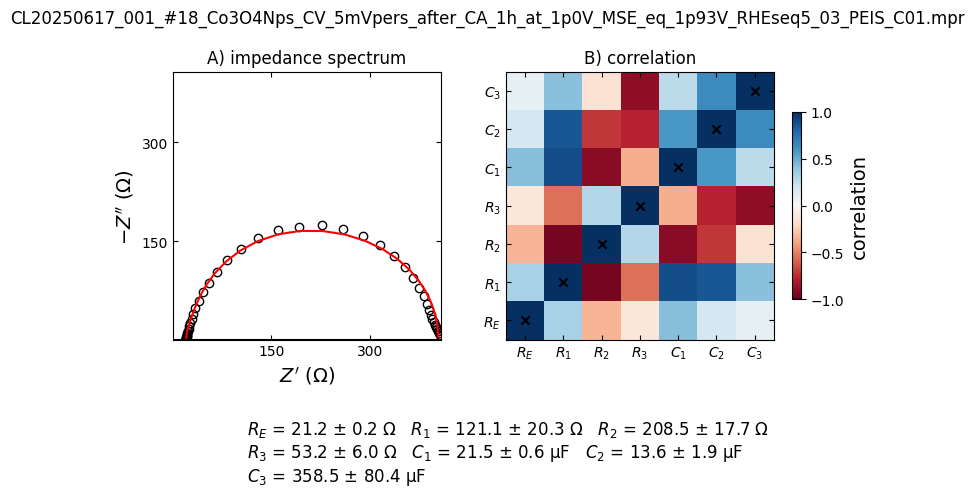

CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq5_06_PEIS_C01.mpr


/opt/homebrew/anaconda3/lib/python3.12/site-packages/uncertainties/core.py:1024: UserWarning: Using UFloat objects with std_dev==0 may give unexpected results.
  warn("Using UFloat objects with std_dev==0 may give unexpected results.")


---weight 0.3---
$R_E$ = 21.4 ± 0.2 $\mathrm{\Omega}$   $R_1$ = 93.2 ± 11.8 $\mathrm{\Omega}$   $R_2$ = 120.1 ± 9.9 $\mathrm{\Omega}$   
$R_3$ = 27.8 ± 4.2 $\mathrm{\Omega}$   $C_1$ = 21.5 ± 0.5 $\mathrm{\mu F}$   $C_2$ = 18.0 ± 2.9 $\mathrm{\mu F}$   
$C_3$ = 451.4 ± 134.2 $\mathrm{\mu F}$   


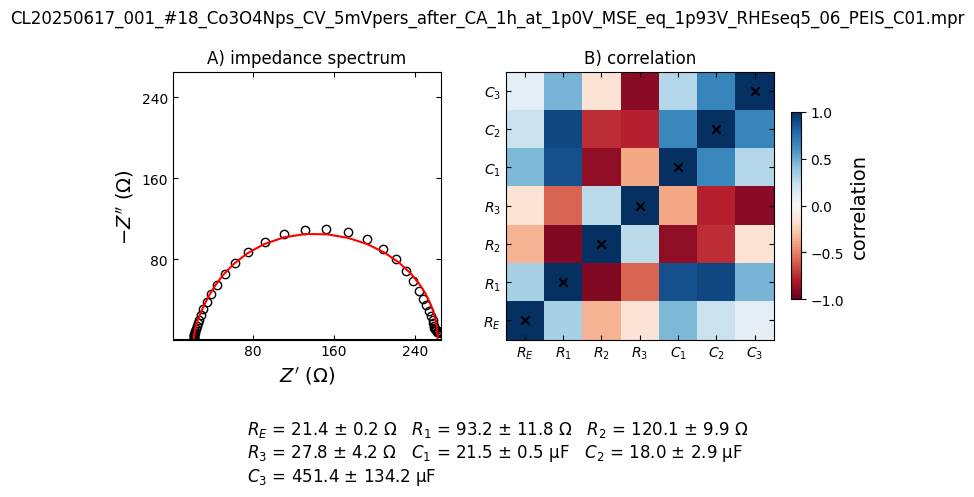

In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from lmfit import Model
from matplotlib.ticker import MaxNLocator
parameters =np.array(['$R_E$', '$R_1$', '$R_2$', '$R_3$', '$C_1$', '$C_2$', '$C_3$'])


def Circuit(freq: NDArray[np.float64], RE: float, R1: float, R2: float, R3: float, C1: float, C2: float, C3: float) -> NDArray[np.float64]:
    '''
                         -----------C1---------------
                        |                          |
    ---RE---------------        --------C2---------|---
                        |       |                  |
                        ---R1---        ---C3---   |
                                |       |      |   |
                                ---R2---        ----
                                        |      |
                                        ---R3---
    '''
    omega = 2*np.pi*freq[:len(freq)//2]
    Z_loop3 = (1/(1/(1j*omega*C3)) + 1/R3)**-1
    Z_loop2 = (1/(1/(1j*omega*C2)) + 1/(R2+Z_loop3))**-1
    Z_loop1 = (1/(1/(1j*omega*C1)) + 1/(R1+Z_loop2))**-1
    Z_model = RE + Z_loop1
    return np.hstack((Z_model.real, Z_model.imag))

def CalculateCorrelation(covariance_matrix: NDArray[np.float64])-> NDArray[np.float64]:
    '''
    Johnson, M. L. Parameter Correlations While Curve Fitting. In Methods in Enzymology; Numerical Computer Methods, Part C; Academic Press, 2000; Vol. 321, pp 424–446. https://doi.org/10.1016/S0076-6879(00)21207-X.
    https://en.wikipedia.org/wiki/Correlation
    '''
    standard_deviation = np.sqrt(np.diag(covariance_matrix))
    matrix_standard_deviation = np.outer(standard_deviation, standard_deviation)
    correlation_matrix = covariance_matrix / matrix_standard_deviation
    return correlation_matrix



###############################

initial_guesses = [
    {'RE': 12, 'R1': 1300, 'R2': 9600,   'R3': 300,    'C1': 20e-6,  'C2': 150e-6, 'C3': 760000e-6 },
    {'RE': 12, 'R1': 5,    'R2': 67,     'R3': 30,     'C1': 20e-6,  'C2': 150e-6, 'C3': 760e-6,   },
    {'RE': 12, 'R1': 90,   'R2': 300,    'R3': 200,    'C1': 120e-6, 'C2': 150e-6, 'C3': 500e-6    },
    {'RE': 12, 'R1': 5,    'R2': 1283.0, 'R3': 4119.9, 'C1': 120e-6, 'C2': 150e-6, 'C3': 76e-6,    },
    {'RE': 12, 'R1': 13,   'R2': 1196.0, 'R3': 7795.9, 'C1': 9e-6,   'C2': 100e-6, 'C3': 50e-6,    }, 
    {'RE': 12, 'R1': 21.7, 'R2': 10226,  'R3': 65300,  'C1': 9e-6,   'C2': 15e-6,  'C3': 3.7e-6,   }, 
    {'RE': 12, 'R1': 10.7, 'R2': 1526,   'R3': 3200,   'C1': 9e-6,   'C2': 50e-6,  'C3': 20e-6,    }, 
    {'RE': 12, 'R1': 7,    'R2': 15,     'R3': 32,     'C1': 8e-6,   'C2': 11e-6,  'C3': 50e-6,    }, 
    {'RE': 12, 'R1': 3,    'R2': 980,    'R3': 860,    'C1': 20e-6,  'C2': 50e-6,  'C3': 30e-6,    }, 
    {'RE': 12, 'R1': 16,   'R2': 4430,   'R3': 79000,  'C1': 10e-6,  'C2': 15e-6,  'C3': 5e-6,     }, 
    {'RE': 12, 'R1': 21.6, 'R2': 940.3,  'R3': 5297.4, 'C1': 4e-6,   'C2': 17e-6,  'C3': 16.2e-6,  }, 
    {'RE': 12, 'R1': 4.5,  'R2':4.5,     'R3': 32.2,   'C1': 11e-6,  'C2': 13.e-6, 'C3': 77e-6,    },
    {'RE': 12, 'R1': 3.8,  'R2':939,     'R3': 5590,   'C1': 19e-6,  'C2': 48.e-6, 'C3': 32e-6,    }]

weight_exponents = np.array([0.3])#np.array([0.9, 0.8, 0.7, 0.6, 0.5, 0.45, 0.4, 0.35, 0.3, 0.25, 0.2, 0.15, 0.1])
threshold = 0.98
threshold_acuracy = 0.8

# Gather all unique sample names and potentials
samples =    sorted(set(AllEisData_indexed.index.get_level_values('fname')))
potentials = list(sorted(set(AllEisData_indexed.index.get_level_values('<Ewe>/V'))))
AllEisFits = pd.DataFrame()
AllEisFitPars = pd.DataFrame()
# Plot data by sample and potential
for i_sample, sample in enumerate(samples):
    print(sample)
    for i_potential, potential in enumerate(potentials):
        EisFits = pd.DataFrame()
        EisFitPars = pd.DataFrame()
        try: 
            df = AllEisData_indexed.loc[(sample, potential)]
            mask = -df['Z"/Ohm'].to_numpy() > 0
            mask[-1] = False 
            frequency = df['freq/Hz'].to_numpy()[mask]
            impedance = df["Z'/Ohm"].to_numpy()[mask] + 1j*df['Z"/Ohm'].to_numpy()[mask]
            best_residual = np.inf
            for guess in initial_guesses:
                for weight_exponent in weight_exponents: 
                    weights = np.hstack((frequency, frequency))**weight_exponent#np.hstack((np.ones(len(frequency)), np.ones(len(frequency))))#
                    model = Model(Circuit)
                    model.set_param_hint('RE', value=guess['RE'],     min=5,  max=70,     vary = True)
                    model.set_param_hint('R1', value=guess['R1'],     min=0,  max=np.inf, vary = True)
                    model.set_param_hint('R2', value=guess['R2'],     min=0,  max=np.inf, vary = True)
                    model.set_param_hint('R3', value=guess['R3'],     min=0,  max=np.inf, vary = True)
                    model.set_param_hint('C1', value=guess['C1'],     min=0,  max=np.inf, vary = True)
                    model.set_param_hint('C2', value=guess['C2'],     min=0,  max=np.inf, vary = True)
                    model.set_param_hint('C3', value=guess['C3'],     min=0,  max=np.inf, vary = True)
                    try:
                        output=model.fit(np.hstack((impedance.real, impedance.imag)), freq=np.hstack((frequency, frequency)), method='leastsq', nan_policy='omit', weights = weights)
                    except Exception: 
                        pass
                    # Evaluate the residual
                    residual = np.sum(output.residual**2)
                    covariance = output.covar
                    params = [param.value for _, param in output.params.items()]
                    errs = [param.stderr for _, param in output.params.items()]
                    try:
                        correlation = np.abs(CalculateCorrelation(covariance))
                    except Exception: 
                        n_critical = len(parameters) + 1   
                        correlation = np.ones((len(parameters), len(parameters)))*np.nan
                    n_critical = np.sum(correlation > threshold)
                    if residual < best_residual:
                        best_weight_exponent = weight_exponent 
                        best_residual = residual
                        fit_tot = (output.best_fit)
                        out = output 
            print(f'---weight {best_weight_exponent}---')
            #### plot the fitted impedance spectrum###
            min_ = np.nanmin(np.hstack((impedance.real, -impedance.imag)))
            max_ = np.nanmax(np.hstack((impedance.real, -impedance.imag)))

            fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (8,4), tight_layout = True)
            fig.suptitle(sample)
            ax[0].set_title('A) impedance spectrum')
            ax[0].tick_params(which='both', direction = 'in', bottom = True, top = True, right = True, left = True)
            ax[0].plot(impedance.real, -impedance.imag, marker = 'o', fillstyle = 'none', linestyle = 'none', color = 'black')
            ax[0].plot(fit_tot[:len(fit_tot)//2], -fit_tot[len(fit_tot)//2:], linestyle = '-',    color = 'red')
            ax[0].set_xlim(min_, max_)
            ax[0].set_ylim(min_, max_)
            ax[0].set_ylabel(r'$-Z^{\prime\prime} \ (\Omega)$', fontsize = 14)
            ax[0].set_xlabel(r'$Z^{\prime} \ (\Omega)$', fontsize = 14)
            ax[0].axhline(y=0, color='black', linestyle='-')
            ax[0].set_aspect('equal')
            ax[0].yaxis.set_major_locator(MaxNLocator(nbins=4))
            ax[0].xaxis.set_major_locator(MaxNLocator(nbins=4))
            params = [param.value for _, param in out.params.items()]
            errs = [param.stderr for _, param in out.params.items()]
            info_string = ''
            ic = 1
            for param_name, param in out.params.items():
                if 'R' in param_name:
                    prefac = 1
                    unit = r'$\mathrm{\Omega}$'
                elif 'L' in param_name:
                    prefac = 1e6
                    unit = r'$\mathrm{\mu H}$'
                elif 'C' in param_name:
                    prefac = 1e6
                    unit = r'$\mathrm{\mu F}$'
                if param.stderr == None: 
                    err = np.nan
                else: 
                    err = np.round(param.stderr*prefac, 1)
                param = np.round(param.value*prefac, 1)
                info_string += f'{parameters[ic-1]} = {param} ± {err} {unit}   '
                
                if ic % 3 == 0: 
                    info_string += '\n' 
                ic += 1 

            print(info_string)
            fig.text(x=0.2, y=-0.2, s = info_string , fontsize=12, color='black')
        
            #############################################

            covariance = out.covar
  
            correlation = CalculateCorrelation(covariance)

            ax[1].set_title('B) correlation')
            ax[1].tick_params(which = 'both', direction = 'in', bottom = True, top = True, left = True, right = True)
            c = ax[1].pcolormesh(parameters[:], parameters[:], correlation, cmap='RdBu', vmin = -1, vmax = 1)

            for i in range(correlation.shape[0]):
                for j in range(correlation.shape[1]):
                    if correlation[i, j] > threshold:
                        ax[1].scatter(parameters[:][j], parameters[:][i], marker='x', color='black')
                    if correlation[i, j] < -threshold: 
                        ax[1].scatter(parameters[:][j], parameters[:][i], marker='x', color='black')
            ax[1].set_aspect('equal')
            cbar = fig.colorbar(c, ax=ax[1], shrink=0.7)
            cbar.set_label('correlation', fontsize=14)
            plt.savefig(fname = f'{sample[:-4]}_corr_RS.tif', dpi = 600, pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')
            plt.show()

            
            EisFitPars = pd.DataFrame({'value': params, 
                                       'error': errs, 
                                       'name': parameters, 
                                       'potential': np.full(np.shape(params), potential), 
                                       'fname': np.full(np.shape(params),sample)})
            AllEisFitPars = pd.concat([AllEisFitPars, EisFitPars])


            impedance_fit = fit_tot[:len(fit_tot)//2]+1j*fit_tot[len(fit_tot)//2:]
            EisFits = pd.DataFrame({'freq/Hz': frequency, 
                                    "Z'/ohm": impedance_fit.real, 
                                    'Z"/ohm': impedance_fit.real, 
                                   'potential': np.full(np.shape(frequency), potential), 
                                   'fname': np.full(np.shape(frequency), sample)})
            AllEisFits = pd.concat([AllEisFits, EisFits])

        except KeyError: 
            pass
        except Exception as E: 
            raise E
        
AllEisFits['info'] = AllEisFits['fname'].map(lambda idx: (
    'pristine' if 'ini' in str(idx) else
    '0.8 V'   if '0p8' in str(idx) else
    '1.0 V'   if 'at_1' in str(idx) else
    'unknown'
))

AllEisFitPars['info'] = AllEisFitPars['fname'].map(lambda idx: (
    'pristine' if 'ini' in str(idx) else
    '0.8 V'   if '0p8' in str(idx) else
    '1.0 V'   if 'at_1' in str(idx) else
    'unknown'
))
AllEisFits.to_parquet('AllEISFits.parquet')
AllEisFits.to_csv('AllEISFits.txt', sep = '\t')
AllEisFitPars.to_parquet('AllEISFitPars.parquet')
AllEisFitPars.to_csv('AllEISFitPars.txt', sep = '\t')


<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
<>:17: SyntaxWarning: invalid escape sequence '\m'
/var/folders/f2/krn3py8536556jbm969hx5380000gn/T/ipykernel_29079/496851958.py:17: SyntaxWarning: invalid escape sequence '\m'
  units = ['($\mathrm{\mu F}$)', '($\mathrm{\mu F}$)', '($\mathrm{\mu F}$)', '($\mathrm{\Omega}$)', '($\mathrm{\Omega}$)', '($\mathrm{\Omega}$)', '($\mathrm{\Om

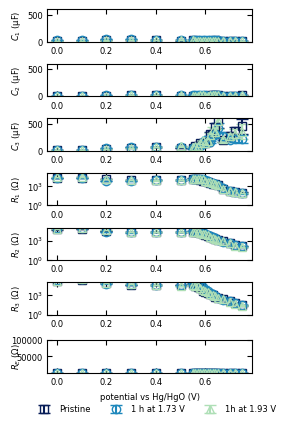

In [3]:
from matplotlib import cm

markers = ['s', 'o', '^']

def colors(i):
    colors = cm.YlGnBu_r((i)*90)#cm.PuRd_r((i)*90)
    return colors

def convert_potential(E_old, pH=13, Eref_old = 0.165): 
    E_new = E_old + Eref_old + 0.059*pH
    return E_new

infos = set(AllEisFitPars['info'])
names = sorted(set(AllEisFitPars['name']))
potentials = sorted(set(AllEisFitPars['potential']))  # ensure consistent x-axis

units = ['($\mathrm{\mu F}$)', '($\mathrm{\mu F}$)', '($\mathrm{\mu F}$)', '($\mathrm{\Omega}$)', '($\mathrm{\Omega}$)', '($\mathrm{\Omega}$)', '($\mathrm{\Omega}$)']
labels= ['Pristine', '1 h at 1.73 V', '1h at 1.93 V']

fig, axs = plt.subplots(nrows=7, figsize=(2.5, 4), sharex=False, constrained_layout = True)
for i_name, name in enumerate(names):
    axs[i_name].tick_params(which = 'both', direction = 'in', bottom = True, left = True, right = True, top = True, labelsize = 6)
    for i_info, info in enumerate(infos): 
        df = AllEisFitPars[(AllEisFitPars['info'] == info) & (AllEisFitPars['name'] == name)]
        df = df[df['potential'] >= 0]
        if i_name in [1,2]:
            axs[i_name].errorbar(x = df['potential'], y = df['value']*1e6, yerr = df['error']*1e6, color = colors(i_info), linestyle = 'none', marker = markers[i_info], capsize = 4, fillstyle = 'none')
        elif i_name == 0: 
            axs[i_name].errorbar(x = df['potential'], y = df['value']*1e6, yerr = df['error']*1e6, color = colors(i_info), linestyle = 'none', marker = markers[i_info], capsize = 4, fillstyle = 'none', label = labels[i_info])
        else: 
            axs[i_name].errorbar(x = df['potential'], y = df['value'], yerr = df['error'], color = colors(i_info), linestyle = 'none', marker = markers[i_info], capsize = 4, fillstyle = 'none')
    
        if i_name in [0,1,2]: 
            axs[i_name].set_ylim(0, 600)
        else: 
            axs[i_name].set_ylim(bottom = 1, top = 10e4)

    axs[i_name].set_ylabel(f'{name} {units[i_name]}', fontsize = 6)
    if i_name in [3,4,5]: 
        axs[i_name].set_yscale('log')
axs[6].set_xlabel('potential vs Hg/HgO (V)', fontsize = 6)
for ax in axs:
    ax.yaxis.set_label_coords(-0.12, 0.5)
fig.legend(bbox_to_anchor=(0.6, -0.01), loc = 'center', ncol = 3, fontsize = 6, frameon = False)

plt.savefig(fname=f"equivalent_circuit_fitting.tif", dpi=600, pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight')
plt.show()


<>:62: SyntaxWarning: invalid escape sequence '\O'
<>:62: SyntaxWarning: invalid escape sequence '\O'
/var/folders/f2/krn3py8536556jbm969hx5380000gn/T/ipykernel_29079/3965303035.py:62: SyntaxWarning: invalid escape sequence '\O'
  ax.set_ylabel('Total resistance $(\Omega)$', fontsize=7)


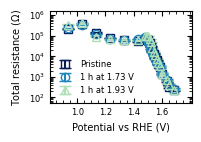

In [4]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import AutoMinorLocator

# --- Customize Appearance ---
markers = ['s', 'o', '^']
labels = ['Pristine', '1 h at 1.73 V', '1 h at 1.93 V']
resistance_names = ['$R_E$', '$R_1$', '$R_2$', '$R_3$']

def colors(i):
    return cm.YlGnBu_r(i * 90)

def convert_potential(E_old, pH=13, Eref_old=0.165):
    return E_old + Eref_old + 0.059 * pH

# --- Extract and Filter Data ---
filtered_df = AllEisFitPars[AllEisFitPars['name'].isin(resistance_names)]
filtered_df = filtered_df[filtered_df['potential'] >= 0]

# --- Group by potential and info, then sum values ---
rtot_df = (
    filtered_df
    .groupby(['potential', 'info'], as_index=False)['value']
    .sum()
    .rename(columns={'value': 'Rtot'})
)

# --- Optional: Merge error if needed (using RMS error combination if multiple resistances contribute) ---
error_df = (
    filtered_df
    .copy()
    .assign(error_sq=lambda df: df['error']**2)
    .groupby(['potential', 'info'], as_index=False)['error_sq']
    .sum()
    .assign(error=lambda df: df['error_sq']**0.5)
    .drop(columns='error_sq')
)
rtot_df = pd.merge(rtot_df, error_df, on=['potential', 'info'])

# --- Plot ---
infos = sorted(rtot_df['info'].unique())

fig, ax = plt.subplots(figsize=[2*0.95, 1.5*0.87], constrained_layout = True)
ax.tick_params(which='both', direction='in', bottom=True, left=True, right=True, top=True, labelsize=6)

for i_info, info in enumerate(infos):
    df = rtot_df[rtot_df['info'] == info]
    ax.errorbar(
        x=convert_potential(df['potential']),
        y=df['Rtot'],
        yerr=df['error'],
        linestyle='none',
        marker=markers[i_info],
        color=colors(i_info),
        capsize=4,
        fillstyle='none',
        label=labels[i_info]
    )

ax.set_ylabel('Total resistance $(\Omega)$', fontsize=7)
ax.set_xlabel('Potential vs RHE (V)', fontsize=7)
ax.yaxis.set_major_locator(MaxNLocator(nbins=4))
ax.legend(fontsize = 6, frameon = False)
#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=6, frameon=False)
ax.set_yscale('log')

ax.margins(x=0.17, y=0.17)
ax.set_xticks([1.0, 1.2, 1.4, 1.6])
ax.xaxis.set_minor_locator(AutoMinorLocator(n = 4))
plt.savefig("Rtot_vs_potential.tif", dpi=600, pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight', transparent=True)
plt.show()


### Make an Interactive Nyquist Plot

<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\m'
<>:61: SyntaxWarning: invalid escape sequence '\m'
<>:62: SyntaxWarning: invalid escape sequence '\m'
/var/folders/f2/krn3py8536556jbm969hx5380000gn/T/ipykernel_29079/2085494302.py:61: SyntaxWarning: invalid escape sequence '\m'
  ax.set_xlabel('Real Part of Impedance ($\mathrm{\Omega}$)', fontsize=12)
/var/folders/f2/krn3py8536556jbm969hx5380000gn/T/ipykernel_29079/2085494302.py:62: SyntaxWarning: invalid escape sequence '\m'
  ax.set_ylabel('-Imaginary Part of Impedance ($\mathrm{\Omega}$)', fontsize=12)
/var/folders/f2/krn3py8536556jbm969hx5380000gn/T/ipykernel_29079/2085494302.py:92: MatplotlibDeprecationWarning: The rectangles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Any custom property styling may be lost.
  for label, line, text, box in zip(col_labels, col_lines, check.labels, check.rectangles):
/var/folders/f2/krn3py8536556jbm969h

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_02_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_05_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_08_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_11_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_14_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_17_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_20_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_03_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_06_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_09_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_12_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_15_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_18_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq4_03_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_s

/var/folders/f2/krn3py8536556jbm969hx5380000gn/T/ipykernel_29079/2085494302.py:92: MatplotlibDeprecationWarning: The rectangles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Any custom property styling may be lost.
  for label, line, text, box in zip(col_labels, col_lines, check.labels, check.rectangles):


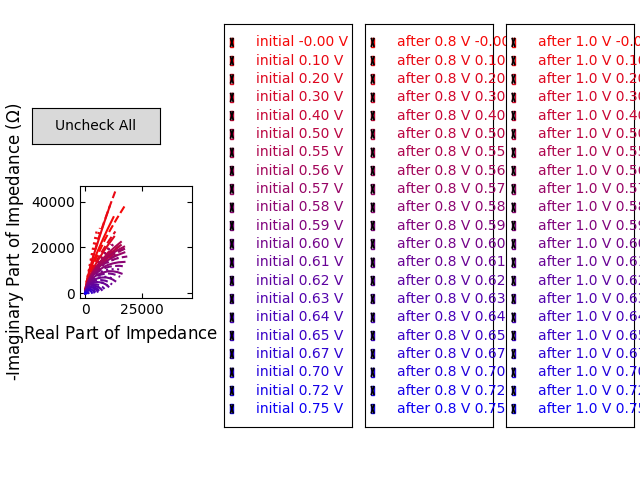

In [5]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import CheckButtons, Button
from matplotlib.colors import LinearSegmentedColormap
import math

%matplotlib widget

# Create figure and axes
fig, ax = plt.subplots()
ax.tick_params(which='both', direction='in', bottom=True, left=True, right=True, top=True)
lines = []

# Define color map
cm_bright = LinearSegmentedColormap.from_list("custom", ["#F50808", "#0000FF"])

# Gather all unique sample names and potentials
samples =    sorted(set(AllEisData_indexed.index.get_level_values('fname')))
potentials = sorted(set(AllEisData_indexed.index.get_level_values('<Ewe>/V')))

# Plot data by sample and potential
for i_sample, sample in enumerate(samples):
    print(sample)
    for i_potential, potential in enumerate(potentials):
        try:
            df = AllEisData_indexed.loc[(sample, potential)]
            linestyle = '-'
            if 'initial' in sample:
                info = 'initial'
                linestyle = ':'
            elif '_at_0' in sample:
                linestyle = '--'
                info = 'after 0.8 V'
            elif '_at_1' in sample:
                linestyle = '-'
                info = 'after 1.0 V'

            lines.append(
                ax.plot(
                    df["Z'/Ohm"].to_numpy(),
                    -df['Z"/Ohm'].to_numpy(),
                    label=f'{info} {np.round(potential, 2):0.2f} V',
                    linestyle=linestyle,
                    color=cm_bright(i_potential / len(potentials))
                )[0]
            )

        except KeyError:
            continue  # this sample didn't have this potential

# Set equal axis aspect and limits
ax.set_aspect('equal')
xlim = ax.get_xlim()
ylim = ax.get_ylim()
lower_limit = min(xlim[0], ylim[0])
upper_limit = max(xlim[1], ylim[1])
ax.set_xlim(lower_limit, upper_limit)
ax.set_ylim(lower_limit, upper_limit)

# Axis labels
ax.set_xlabel('Real Part of Impedance ($\mathrm{\Omega}$)', fontsize=12)
ax.set_ylabel('-Imaginary Part of Impedance ($\mathrm{\Omega}$)', fontsize=12)

# Create CheckButtons with 3 columns
labels = [line.get_label() for line in lines]
visibility = [line.get_visible() for line in lines]

n_cols = 3
n_labels = len(labels)
per_col = math.ceil(n_labels / n_cols)

label_columns = [labels[i * per_col:(i + 1) * per_col] for i in range(n_cols)]
visibility_columns = [visibility[i * per_col:(i + 1) * per_col] for i in range(n_cols)]
line_columns = [lines[i * per_col:(i + 1) * per_col] for i in range(n_cols)]

checkboxes = []

for i in range(n_cols):
    col_labels = label_columns[i]
    col_vis = visibility_columns[i]
    col_lines = line_columns[i]

    col_width = 0.2
    spacing = 0.02
    left = 0.35 + i * (col_width + spacing)
    height = min(0.04 * len(col_labels), 0.9)
    y_start = 0.95 - height

    rax = plt.axes([left, y_start, col_width, height])
    check = CheckButtons(rax, col_labels, col_vis)

    for label, line, text, box in zip(col_labels, col_lines, check.labels, check.rectangles):
        color = line.get_color()
        text.set_color(color)
        box.set_edgecolor(color)
        box.set_facecolor('white')  # Or use a faint version of the line color if preferred

    checkboxes.append((check, col_labels, col_lines))



# Toggle visibility
def toggle(label):
    for check, labels_col, lines_col in checkboxes:
        if label in labels_col:
            index = labels_col.index(label)
            lines_col[index].set_visible(not lines_col[index].get_visible())
    #ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.draw()


for check, _, _ in checkboxes:
    check.on_clicked(toggle)

# Uncheck All button
button_ax = plt.axes([0.05, 0.7, 0.2, 0.075])
button = Button(button_ax, 'Uncheck All')
def uncheck_all(event):
    for check, labels_col, _ in checkboxes:
        statuses = check.get_status()
        for i, status in enumerate(statuses):
            if status:  # Only uncheck if currently checked
                check.set_active(i)



button.on_clicked(uncheck_all)

#ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.subplots_adjust(right=0.3)
plt.show()


In [6]:
convert_potential(AllEisData_indexed.index.get_level_values(1).unique())

Index([0.9320000410079956, 1.0320000648498535, 1.1319999694824219,
       1.2320001125335693, 1.3320000171661377, 1.4320000410079956,
       1.4820001125335693, 1.4920001029968262,  1.502000093460083,
       1.5120000839233398, 1.5220000743865967, 1.5320000648498535,
       1.5420000553131104, 1.5520000457763672,  1.562000036239624,
       1.5720000267028809, 1.5820000171661377, 1.6019999980926514,
       1.6319999694824219,  1.652000069618225, 1.6820000410079956],
      dtype='float32', name='<Ewe>/V')

## EIS Plot

<>:77: SyntaxWarning: invalid escape sequence '\p'
<>:78: SyntaxWarning: invalid escape sequence '\p'
<>:77: SyntaxWarning: invalid escape sequence '\p'
<>:78: SyntaxWarning: invalid escape sequence '\p'
/var/folders/f2/krn3py8536556jbm969hx5380000gn/T/ipykernel_29079/2044876740.py:77: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$Z^{\prime} \ \mathrm{(k \Omega)}$', fontsize=7)
/var/folders/f2/krn3py8536556jbm969hx5380000gn/T/ipykernel_29079/2044876740.py:78: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$-Z^{\prime \prime} \ \mathrm{(k \Omega)}$', fontsize=7)


CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_02_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_05_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_08_PEIS_C01.mpr
1.1320000029802322
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_11_PEIS_C01.mpr
1.232000011920929
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_14_PEIS_C01.mpr
1.3320000059604644
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_17_PEIS_C01.mpr
1.432
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_20_PEIS_C01.mpr
1.482000011920929
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_03_PEIS_C01.mpr
1.4920000023841857
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_06_PEIS_C01.mpr
1.5019999928474426
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_09_PEIS_C01.mpr
1.5119999833106994
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_12_PEIS_C01.mpr
1.5219999737739562
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_15_PEIS_C01.mpr
1.5320000238418578
CL2025061

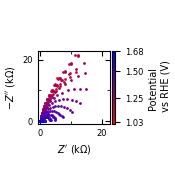

In [7]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import CheckButtons, Button
from matplotlib.colors import LinearSegmentedColormap
import math
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator

%matplotlib widget

def convert_potential(E_old, pH=13, Eref_old = 0.165): 
    E_new = E_old + Eref_old + 0.059*pH
    return E_new

# Create figure and axes
fig, ax = plt.subplots(figsize=[1.7*1.03,1.7*1.03], constrained_layout = True)
ax.tick_params(which='both', direction='in', bottom=True, left=True, right=True, top=True, labelsize = 6)
lines = []

# Define color map
cm_bright = LinearSegmentedColormap.from_list("custom", ["#F50808", "#0000FF"])

# Gather all unique sample names and potentials
samples =    sorted(set(AllEisData_indexed.index.get_level_values('fname')))
potentials = sorted(set(AllEisData_indexed.index.get_level_values('<Ewe>/V')))[2:]

potentials_RHE = convert_potential(np.array(potentials))

# Plot data by sample and potential
for i_sample, sample in enumerate(samples):
    print(sample)
    for i_potential, potential in enumerate(potentials):
        try:
            df = AllEisData_indexed.loc[(sample, potential)]
            potential = convert_potential(potential)
            print(potential)
            linestyle = '-'
            if 'initial' in sample:
                info = 'initial'
                linestyle = '-'
                lines.append(
                ax.plot(
                    df["Z'/Ohm"].to_numpy()/1000,
                    -df['Z"/Ohm'].to_numpy()/1000,
                    label=f'{np.round(potential, 2):0.2f} V',
                    linestyle='none',
                    marker = 'o',
                    markersize = 1,
                    color=cm_bright(i_potential / len(potentials))
                )[0]
            )
            elif '_at_0' in sample:
                linestyle = '--'
                info = 'after 0.8 V'
            elif '_at_1' in sample:
                linestyle = '-'
                info = 'after 1.0 V'

            

        except KeyError:
            continue  # this sample didn't have this potential

# Set equal axis aspect and limits
ax.set_aspect('equal')
ax.set_ylim(bottom = 0) 
xlim = ax.get_xlim()
ylim = ax.get_ylim()
lower_limit = min(xlim[0], ylim[0])
upper_limit = max(xlim[1], ylim[1])
ax.set_xlim(lower_limit, upper_limit)
ax.set_ylim(lower_limit, upper_limit)

# Axis labels
ax.set_xlabel('$Z^{\prime} \ \mathrm{(k \Omega)}$', fontsize=7)
ax.set_ylabel('$-Z^{\prime \prime} \ \mathrm{(k \Omega)}$', fontsize=7)

norm = mcolors.Normalize(vmin=1.68, vmax=1.13)  # reversed color scale
sm = cm.ScalarMappable(cmap=cm_bright, norm=norm)
sm.set_array([1.03, 1.25, 1.5, 1.68])

cbar = plt.colorbar(sm, ax=ax, pad=0.02, fraction=0.05)
cbar.set_label('Potential \n vs RHE (V)', fontsize=7)
cbar.ax.tick_params(labelsize=6)
cbar.set_ticks([1.03, 1.25, 1.5, 1.68])#locator = MaxNLocator(nbins=8)  # Set desired number of ticks
cbar.update_ticks()

from matplotlib.ticker import FixedLocator
ax.yaxis.set_minor_locator(AutoMinorLocator(n = 2))
ax.xaxis.set_minor_locator(AutoMinorLocator(n = 2))
ax.yaxis.set_major_locator(FixedLocator([0, 20, 40]))
ax.xaxis.set_major_locator(FixedLocator([0, 20, 40]))
#ax.legend(loc='center', bbox_to_anchor=(0.5, -0.8), frameon = False, ncol = 3, fontsize = 6)
plt.savefig(fname=f"EIS_all.tif", dpi=600, pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight', transparent = True)
plt.show()


<>:80: SyntaxWarning: invalid escape sequence '\p'
<>:81: SyntaxWarning: invalid escape sequence '\p'
<>:80: SyntaxWarning: invalid escape sequence '\p'
<>:81: SyntaxWarning: invalid escape sequence '\p'
/var/folders/f2/krn3py8536556jbm969hx5380000gn/T/ipykernel_29079/2440538915.py:80: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$Z^{\prime} \ \mathrm{(k \Omega)}$', fontsize=7)
/var/folders/f2/krn3py8536556jbm969hx5380000gn/T/ipykernel_29079/2440538915.py:81: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$-Z^{\prime \prime} \ \mathrm{(k \Omega)}$', fontsize=7)


CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_02_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_05_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_08_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_11_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_14_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_17_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_20_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_03_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_06_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_09_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_12_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_15_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq3_18_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq4_03_PEIS_C01.mpr
CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_s

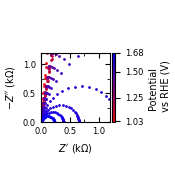

In [8]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import CheckButtons, Button
from matplotlib.colors import LinearSegmentedColormap
import math
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.colors as mcolors

%matplotlib widget

def convert_potential(E_old, pH=13, Eref_old = 0.165): 
    E_new = E_old + Eref_old + 0.059*pH
    return E_new

# Create figure and axes
fig, ax = plt.subplots(figsize=[1.7*1.03,1.7*1.03], constrained_layout = True)
ax.tick_params(which='both', direction='in', bottom=True, left=True, right=True, top=True, labelsize = 6)
lines = []

# Define color map
cm_bright = LinearSegmentedColormap.from_list("custom", ["#F50808", "#0000FF"])

# Gather all unique sample names and potentials
samples =    sorted(set(AllEisData_indexed.index.get_level_values('fname')))
potentials = sorted(set(AllEisData_indexed.index.get_level_values('<Ewe>/V')))

potentials_RHE = convert_potential(np.array(potentials))

# Plot data by sample and potential
for i_sample, sample in enumerate(samples):
    print(sample)
    for i_potential, potential in enumerate(potentials):
        try:
            df = AllEisData_indexed.loc[(sample, potential)]
            linestyle = '-'
            if 'initial' in sample:
                info = 'initial'
                linestyle = '-'
                potential = convert_potential(potential)
                lines.append(
                ax.plot(
                    df["Z'/Ohm"].to_numpy()/1000,
                    -df['Z"/Ohm'].to_numpy()/1000,
                    label=f'{np.round(potential, 2):0.2f} V',
                    linestyle= 'none',
                    marker = 'o', 
                    markersize = 1,
                    color=cm_bright(i_potential / len(potentials))
                )[0]
            )
            elif '_at_0' in sample:
                linestyle = '--'
                info = 'after 0.8 V'
            elif '_at_1' in sample:
                linestyle = '-'
                info = 'after 1.0 V'

            

        except KeyError:
            continue  # this sample didn't have this potential

# Set equal axis aspect and limits
ax.set_aspect('equal')
ax.set_ylim(bottom = 0, top = 1.200) 
ax.set_xlim(left = 0, right = 1.200) 
xlim = ax.get_xlim()
ylim = ax.get_ylim()
lower_limit = min(xlim[0], ylim[0])
upper_limit = max(xlim[1], ylim[1])
ax.set_xlim(lower_limit, upper_limit)
ax.set_ylim(lower_limit, upper_limit)
from matplotlib.ticker import MaxNLocator

from matplotlib.ticker import FixedLocator

ax.yaxis.set_major_locator(FixedLocator([0, 0.5, 1]))
ax.xaxis.set_major_locator(FixedLocator([0, 0.5, 1]))
ax.set_xlabel('$Z^{\prime} \ \mathrm{(k \Omega)}$', fontsize=7)
ax.set_ylabel('$-Z^{\prime \prime} \ \mathrm{(k \Omega)}$', fontsize=7)

norm = mcolors.Normalize(vmin=1.68, vmax=1.13)  # reversed color scale
sm = cm.ScalarMappable(cmap=cm_bright, norm=norm)
sm.set_array([1.03, 1.25, 1.5, 1.68])

cbar = plt.colorbar(sm, ax=ax, pad=0.02, fraction=0.05)
cbar.set_label('Potential \n vs RHE (V)', fontsize=7)
cbar.ax.tick_params(labelsize=6)
cbar.set_ticks([1.03, 1.25, 1.5, 1.68])#locator = MaxNLocator(nbins=8)  # Set desired number of ticks
cbar.update_ticks()
ax.margins(x=0.17, y=0.17)
ax.yaxis.set_minor_locator(AutoMinorLocator(n = 2))
ax.xaxis.set_minor_locator(AutoMinorLocator(n = 2))
#ax.legend(loc='center', bbox_to_anchor=(0.5, -0.8), frameon = False, ncol = 3, fontsize = 6)
plt.savefig(fname=f"EIS_zoom.tif", dpi=600, pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight', transparent = True)
plt.show()


## Comparison at 0.1 V

CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq2_05_PEIS_C01.mpr
CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq2_05_PEIS_C01.mpr
CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq2_05_PEIS_C01.mpr


<>:78: SyntaxWarning: invalid escape sequence '\p'
<>:79: SyntaxWarning: invalid escape sequence '\p'
<>:78: SyntaxWarning: invalid escape sequence '\p'
<>:79: SyntaxWarning: invalid escape sequence '\p'
/var/folders/f2/krn3py8536556jbm969hx5380000gn/T/ipykernel_29079/3607575494.py:78: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$Z^{\prime} \ \mathrm{(k \Omega)}$', fontsize=7)
/var/folders/f2/krn3py8536556jbm969hx5380000gn/T/ipykernel_29079/3607575494.py:79: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$-Z^{\prime \prime} \ \mathrm{(k \Omega)}$', fontsize=7)


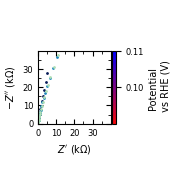

In [9]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import CheckButtons, Button
from matplotlib.colors import LinearSegmentedColormap
import math
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.colors as mcolors

%matplotlib widget
def colors(i):
    colors = cm.YlGnBu_r((i)*90)#cm.PuRd_r((i)*90)
    return colors
# Create figure and axes
fig, ax = plt.subplots(figsize=[1.7/0.97,1.7/0.97], constrained_layout = True)
ax.tick_params(which='both', direction='in', bottom=True, left=True, right=True, top=True, labelsize = 6)
lines = []

# Define color map
cm_bright = LinearSegmentedColormap.from_list("custom", ["#F50808", "#0000FF"])

# Gather all unique sample names and potentials
samples =    sorted(set(AllEisData_indexed.index.get_level_values('fname')))
potentials = [sorted(set(AllEisData_indexed.index.get_level_values('<Ewe>/V')))[1]]

# Plot data by sample and potential
ic = 0
labels = ['pristine', '1 h CA at 0.8 V', '1 h CA at 1.0 V']
for i_sample, sample in enumerate(samples):
    
    for i_potential, potential in enumerate(potentials):
        try:
            df = AllEisData_indexed.loc[(sample, potential)]
            print(sample)
            linestyle = '-'
            if 'initial' in sample:
                info = 'initial'
                linestyle = '-'

            elif '_at_0' in sample:
                linestyle = '-'
                info = 'after 0.8 V'
            elif '_at_1' in sample:
                linestyle = '-'
                info = 'after 1.0 V'

            lines.append(
                ax.plot(
                    df["Z'/Ohm"].to_numpy()/1000,
                    -df['Z"/Ohm'].to_numpy()/1000,
                    label=labels[ic],
                    linestyle='none',
                    marker = 'o', 
                    markersize = 1,
                    color=colors(i=ic)
                )[0]
            )
            ic +=1
        except KeyError:
            continue  # this sample didn't have this potential

# Set equal axis aspect and limits
ax.set_aspect('equal')
ax.set_ylim(bottom = 0, top = 40) 
ax.set_xlim(left = 0) 
xlim = ax.get_xlim()
ylim = ax.get_ylim()
lower_limit = min(xlim[0], ylim[0])
upper_limit = max(xlim[1], ylim[1])
ax.set_xlim(lower_limit, upper_limit)
ax.set_ylim(lower_limit, upper_limit)
from matplotlib.ticker import MaxNLocator

from matplotlib.ticker import FixedLocator

ax.yaxis.set_major_locator(FixedLocator([0, 10, 20, 30]))
ax.xaxis.set_major_locator(FixedLocator([0, 10, 20, 30]))
ax.set_xlabel('$Z^{\prime} \ \mathrm{(k \Omega)}$', fontsize=7)
ax.set_ylabel('$-Z^{\prime \prime} \ \mathrm{(k \Omega)}$', fontsize=7)

norm = mcolors.Normalize(vmin=max(potentials), vmax=min(potentials))  # reversed color scale
sm = cm.ScalarMappable(cmap=cm_bright, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, pad=0.02, fraction=0.05)
cbar.set_label('Potential \n vs RHE (V)', fontsize=7)
cbar.ax.tick_params(labelsize=6)
ax.margins(x=0.17, y=0.17)
ax.yaxis.set_minor_locator(AutoMinorLocator(n = 2))
ax.xaxis.set_minor_locator(AutoMinorLocator(n = 2))
#ax.legend(loc='center', bbox_to_anchor=(0.5, -0.8), frameon = False, ncol = 1, fontsize = 6)
plt.savefig(fname=f"EIS_comparison_at_{np.round(potential, 2)}V.tif", dpi=600, pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight', transparent = True)
plt.show()


## Comparison at 0.67 V

<>:82: SyntaxWarning: invalid escape sequence '\p'
<>:83: SyntaxWarning: invalid escape sequence '\p'
<>:82: SyntaxWarning: invalid escape sequence '\p'
<>:83: SyntaxWarning: invalid escape sequence '\p'
/var/folders/f2/krn3py8536556jbm969hx5380000gn/T/ipykernel_29079/3730811366.py:82: SyntaxWarning: invalid escape sequence '\p'
  ax.set_xlabel('$Z^{\prime} \ \mathrm{(k \Omega)}$', fontsize=7)
/var/folders/f2/krn3py8536556jbm969hx5380000gn/T/ipykernel_29079/3730811366.py:83: SyntaxWarning: invalid escape sequence '\p'
  ax.set_ylabel('$-Z^{\prime \prime} \ \mathrm{(k \Omega)}$', fontsize=7)


CL20250616_003_#18_Co3O4Nps_CV_5mVpers_initial_seq4_15_PEIS_C01.mpr
CL20250616_004_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_0p8V_MSE_eq_1p73V_RHE_seq4_15_PEIS_C01.mpr
CL20250617_001_#18_Co3O4Nps_CV_5mVpers_after_CA_1h_at_1p0V_MSE_eq_1p93V_RHEseq4_15_PEIS_C01.mpr


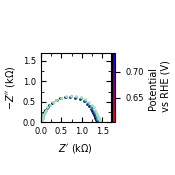

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import CheckButtons, Button
from matplotlib.colors import LinearSegmentedColormap
import math
import matplotlib.cm as cm
import matplotlib.colorbar as colorbar
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FixedLocator

%matplotlib widget
def colors(i):
    colors = cm.YlGnBu_r((i)*90)#cm.PuRd_r((i)*90)
    return colors
# Create figure and axes
fig, ax = plt.subplots(figsize=[1.7*1.03,1.7*1.03], constrained_layout = True)
ax.tick_params(which='both', direction='in', bottom=True, left=True, right=True, top=True, labelsize = 6)
lines = []

# Define color map
cm_bright = LinearSegmentedColormap.from_list("custom", ["#F50808", "#0000FF"])

# Gather all unique sample names and potentials
samples =    sorted(set(AllEisData_indexed.index.get_level_values('fname')))
potentials = [sorted(set(AllEisData_indexed.index.get_level_values('<Ewe>/V')))[-4]]

# Plot data by sample and potential
ic = 0
labels = ['Pristine', '1 h CA at 0.8 V', '1 h CA at 1.0 V']
for i_sample, sample in enumerate(samples):
    
    for i_potential, potential in enumerate(potentials):
        try:
            df = AllEisData_indexed.loc[(sample, potential)]
            print(sample)
            linestyle = '-'
            if 'initial' in sample:
                info = 'initial'
                linestyle = '-'

            elif '_at_0' in sample:
                linestyle = '-'
                info = 'after 0.8 V'
            elif '_at_1' in sample:
                linestyle = '-'
                info = 'after 1.0 V'

            lines.append(
                ax.plot(
                    df["Z'/Ohm"].to_numpy()/1000,
                    -df['Z"/Ohm'].to_numpy()/1000,
                    label=labels[ic],
                    linestyle='none',
                    marker = 'o', 
                    markersize = 1,
                    color=colors(i=ic)
                )[0]
            )
            ic +=1
        except KeyError:
            continue  # this sample didn't have this potential

# Set equal axis aspect and limits
ax.set_aspect('equal')

ax.set_ylim(bottom = 0, top = 1.7) 
ax.set_xlim(left = 0, right = 1.7) 


xlim = ax.get_xlim()
ylim = ax.get_ylim()


lower_limit = min(xlim[0], ylim[0])
upper_limit = max(xlim[1], ylim[1])
ax.set_xlim(lower_limit, upper_limit)
ax.set_ylim(lower_limit, upper_limit)

ax.yaxis.set_major_locator(FixedLocator([0, 0.5, 1.0, 1.5]))
ax.xaxis.set_major_locator(FixedLocator([0, 0.5, 1.0, 1.5]))
ax.set_xlabel('$Z^{\prime} \ \mathrm{(k \Omega)}$', fontsize=7)
ax.set_ylabel('$-Z^{\prime \prime} \ \mathrm{(k \Omega)}$', fontsize=7)

norm = mcolors.Normalize(vmin=max(potentials), vmax=min(potentials))  # reversed color scale
sm = cm.ScalarMappable(cmap=cm_bright, norm=norm)
sm.set_array([])

cbar = plt.colorbar(sm, ax=ax, pad=0.02, fraction=0.05)
cbar.set_label('Potential \n vs RHE (V)', fontsize=7)
cbar.ax.tick_params(labelsize=6)
ax.yaxis.set_minor_locator(AutoMinorLocator(n = 2))
ax.xaxis.set_minor_locator(AutoMinorLocator(n = 2))
ax.margins(x=0.17, y=0.17)
#ax.legend(loc='center', bbox_to_anchor=(0.5, -0.8), frameon = False, ncol = 1, fontsize = 6)
plt.savefig(fname=f"EIS_comparison_at_{np.round(potential, 2)}V.tif", dpi=600, pil_kwargs={"compression": "tiff_lzw"}, bbox_inches='tight', transparent = True)
plt.show()
